# Contexte et objectifs :

**Ce projet utilise un jeu de données clinique sur les maladies thyroïdiennes, disponible sur Kaggle :**
https://www.kaggle.com/datasets/emmanuelfwerr/thyroid-disease-data/data

Le dataset contient des informations démographiques, cliniques et biologiques de patients, incluant notamment des mesures hormonales (TSH, T3, T4, etc.), ainsi que des étiquettes de diagnostic correspondant à différents types de dysfonctionnements thyroïdiens.

L’objectif est de développer un modèle de Machine Learning capable de prédire le diagnostic thyroïdien d’un patient à partir de ses données médicales. Nous abordons le problème en deux étapes :
- Classification en 3 classes : sain / hyperthyroïdie / hypothyroïdie 
- Classification en 6 classes pour une interprétation plus fine des pathologies

Défis du dataset :
- Problème de classification multiclasses 
- Forte imbalance (certaines pathologies sont rares, et on a une grande majorité d'individus sains)
- Mélange de variables booléennes, catégorielles et continues
- Besoin de gérer des valeurs manquantes issues des mesures biologiques non réalisées chez certains patients

=> Cependant, l’existence de biomarqueurs hormonaux robustes (ex. TSH, T3, T4) permet théoriquement une bonne séparation entre les classes, rendant le problème scientifiquement pertinent.

# Import des modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import des données

In [2]:
data=pd.read_csv("/Users/mafaldafrere/Documents/Cours/IODAA/PROG/PROJET/classif_thyroid_disease/thyroidDF.csv")
data.head()

age sex on_thyroxine query_on_thyroxine on_antithyroid_meds sick pregnant  \
0   29   F            f                  f                   f    f        f   
1   29   F            f                  f                   f    f        f   
2   41   F            f                  f                   f    f        f   
3   36   F            f                  f                   f    f        f   
4   32   F            f                  f                   f    f        f   

  thyroid_surgery I131_treatment query_hypothyroid  ...    TT4 T4U_measured  \
0               f              f                 t  ...    NaN            f   
1               f              f                 f  ...  128.0            f   
2               f              f                 f  ...    NaN            f   
3               f              f                 f  ...    NaN            f   
4               f              f                 f  ...    NaN            f   

  T4U FTI_measured FTI TBG_measured   TBG  referral_source target  patient_id  
0 NaN            f NaN            f   NaN            other      -   840801013  
1 NaN            f NaN            f   NaN            other      -   840801014  
2 NaN            f NaN            t  11.0            other      -   840801042  
3 NaN            f NaN            t  26.0            other      -   840803046  
4 NaN            f NaN            t  36.0            other      S   840803047  

[5 rows x 31 columns]

**Premières observations :**
- On observe des variables mesurées post-diagnostic (ex: type de traitement), cela risque de provoquer du data leakage dans la tâche que je me suis posée (diagnostic)
- Variables redondantes telles que "T4U_measured" => indique si l'hormone T4U a été mesurée chez l'individu
- Beaucoup de NA sur certaines colonnes => comment gérer ? 
- Prédiction multi-classes (20 classes!!!): réduire le nombre de classes et garder le problème pertinent
- Gestion de classes déséquilibrées

# 1. Exploration Préliminaire
## A. Colonnes diverses de X
Dans le dataset il y a des mesures de taux d'hormones, et à chaque colonne numérique de mesure est associée une colonne indiquant si oui ou non la mesure a été réalisée. Ces colonnes n'apportent aucune information supplémentaire (car se traduisent par un Na dans la colonne numérique de mesure). On drop ces colonnes.

**=> J'avais commencé par retirer ces données, puis je les ai finalement rajoutées au moment de réaliser le modèle car je me suis rendue compte qu'elles permettent de gérer les Na !**

In [3]:
data.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured','FTI_measured', 'TBG_measured'], axis=1, inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  9172 non-null   int64  
 1   sex                  8865 non-null   object 
 2   on_thyroxine         9172 non-null   object 
 3   query_on_thyroxine   9172 non-null   object 
 4   on_antithyroid_meds  9172 non-null   object 
 5   sick                 9172 non-null   object 
 6   pregnant             9172 non-null   object 
 7   thyroid_surgery      9172 non-null   object 
 8   I131_treatment       9172 non-null   object 
 9   query_hypothyroid    9172 non-null   object 
 10  query_hyperthyroid   9172 non-null   object 
 11  lithium              9172 non-null   object 
 12  goitre               9172 non-null   object 
 13  tumor                9172 non-null   object 
 14  hypopituitary        9172 non-null   object 
 15  psych                9172 non-null   o

In [6]:
# Premières observations des variables numériques
data.describe()

age          TSH           T3          TT4          T4U  \
count   9172.000000  8330.000000  6568.000000  8730.000000  8363.000000   
mean      73.555822     5.218403     1.970629   108.700305     0.976056   
std     1183.976718    24.184006     0.887579    37.522670     0.200360   
min        1.000000     0.005000     0.050000     2.000000     0.170000   
25%       37.000000     0.460000     1.500000    87.000000     0.860000   
50%       55.000000     1.400000     1.900000   104.000000     0.960000   
75%       68.000000     2.700000     2.300000   126.000000     1.065000   
max    65526.000000   530.000000    18.000000   600.000000     2.330000   

               FTI         TBG    patient_id  
count  8370.000000  349.000000  9.172000e+03  
mean    113.640746   29.870057  8.529473e+08  
std      41.551650   21.080504  7.581969e+06  
min       1.400000    0.100000  8.408010e+08  
25%      93.000000   21.000000  8.504090e+08  
50%     109.000000   26.000000  8.510040e+08  
75%     128.000000   31.000000  8.607110e+08  
max     881.000000  200.000000  8.701190e+08

**Observations :**
- L'âge max est à 65526 ???

In [368]:
data[data.age > 100]

age sex on_thyroxine query_on_thyroxine on_antithyroid_meds sick  \
2976    455   F            f                  f                   f    f   
5710  65511   M            f                  f                   f    f   
6392  65512   M            f                  f                   f    f   
8105  65526   F            f                  f                   f    f   

     pregnant thyroid_surgery I131_treatment query_hypothyroid  ... psych  \
2976        f               f              f                 f  ...     f   
5710        f               f              f                 f  ...     f   
6392        f               f              f                 f  ...     f   
8105        f               f              f                 f  ...     f   

       TSH   T3    TT4   T4U    FTI  TBG  referral_source  target  patient_id  
2976  1.10  2.0  118.0  1.13  104.0  NaN              SVI       -   850530001  
5710  0.38  2.0  113.0  1.08  104.0  NaN            other       -   860210008  
6392  0.03  2.8  112.0  0.84  133.0  NaN            other       -   860403050  
8105  1.50  NaN  132.0  1.02  129.0  NaN            other       -   861014041  

[4 rows x 25 columns]

Effectivement, nous avons 4 individus d'âge largement supérieur à 100 (pas cohérent). Je décide de mettre ces valeurs à Na. 

In [7]:
data['age'] = np.where((data.age > 100), np.nan, data.age)

Je regarde si il y a des duplicats de lignes, et de patient_ID. 

In [8]:
print(data.duplicated().any())
print(data.duplicated(subset=['patient_id']).any())

False
False


Il n'y a aucun duplicat donc je retire patient_id puisqu'il n'apporte aucune information. Je décide également de retirer la colonne "referral_source", qui indique par quel moyen le patient a effectué les tests pour les maladies de la thyroïde. Cette colonne pourrait apporter un biais (certaines sources peuvent amener plus de malades), et elle n'apporte pas beaucoup d'information de toute façon.  

In [9]:
data.drop(['patient_id', 'referral_source'], axis=1, inplace=True)

Enfin, plusieurs colonnes sont liées à un traitement médical post-diagnostic ('on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds' 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid'). Dans le cadre d'un modèle de diagnostic, ce n'est pas très réaliste de les inclure. On va cependant les garder pour le moment et voir avec un premier modèle baseline si effectivement l'accuracy chute lorsqu'on les retire (ce qui indiquerait qu'on a affaire à du data leakage).

## B. Colonne Target
La colonne "target" fait référence au diagnostic (c'est notre variable cible). C'est une colonne avec beaucoup de classes, et un formalisme particulier. Le diagnostic consiste en une chaîne de caractères, chaque caractère faisant référence à une pathologie. On peut aussi avoir des structures de type "X|Y", où le diagnostic est cohérent pour la pathologie X mais où le patient est plus probablement atteint de la pathologie Y. Egalement, si le patient est atteint de plusieurs pathologies comme X et Y, le diagnostic s'écrit "XY". De plus, les pathologies sont regroupées en méta-catégories dans la documentation Kaggle associée au dataset. 
Il y a donc quelques modifications possibles sur cette colonne. (Voir la documentation Kaggle sur ce dataset pour avoir les correspondance lettre - pathologie).

In [10]:
data['target'].value_counts()

target
-      6771
K       436
G       359
I       346
F       233
R       196
A       147
L       115
M       111
N       110
S        85
GK       49
AK       46
J        30
B        21
MK       16
O        14
Q        14
C|I      12
KJ       11
GI       10
H|K       8
D         8
FK        6
C         6
P         5
MI        2
LJ        1
GKJ       1
OI        1
D|R       1
E         1
Name: count, dtype: int64

Je décide de commencer par retirer les doubles/triples diagnostics. En effet, je cherche à faire un modèle interprétable pour voir le lien feature - diagnostic. Si je ne garde qu'un des diagnostics, je risque de brouiller les résultats (le modèle identifierai des biomarqueurs des autres pathologies et ferait des erreurs à juste titre).
Par contre, pour les cas "X|Y", je conserve Y (le diagnostic le plus probable).

In [11]:
def clean_target(label):
    # pipe: garder la partie après |
    label = label.split('|')[-1]

    if len(label) > 1:
        return None
    
    return label

data['target'] = data['target'].apply(clean_target)
data = data[~data['target'].isna()]


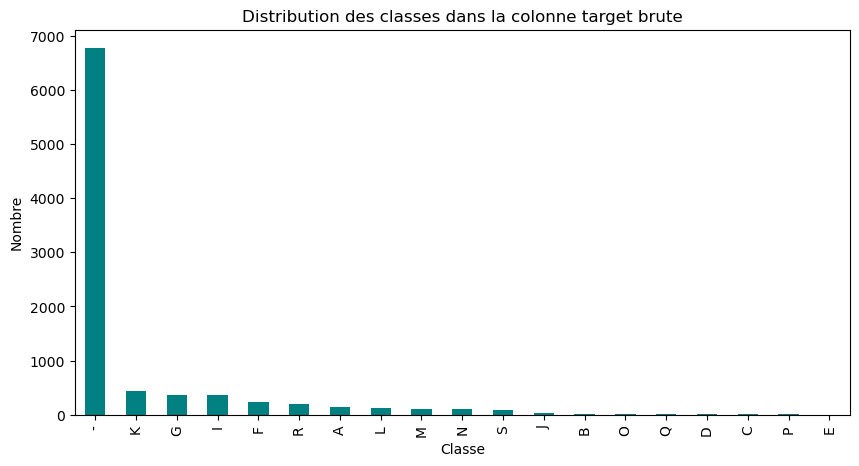

In [12]:
y=data.target

y.value_counts().plot(kind='bar', figsize=(10,5), color='teal')
plt.title("Distribution des classes dans la colonne target brute")
plt.xlabel("Classe")
plt.ylabel("Nombre")
plt.show()

On observe que les classes sont très déséquilibrées avec beaucoup d'individus sains et très peu d'individus pour les autres catégories. Je fais le choix pour le moment de faire 3 classes : on regroupe certaines catégories pour créer des méta-catégories (sain, hyperthyroïdie, hypothyroïdie : voir documentation du dataset kaggle). Je choisis aussi de retirer les individus des catégories qui ne rentrent pas dans ces méta-catégories (effectif faible de toute façon). On crée ainsi un premier set de classes, assez simple, mais toujours déséquilibré!

### a. Target version 3 classes

In [13]:
data_3class = data.copy()

# On mappe les meta-catégories
diagnostics = {'-': 'negative',
             'A': 'hyperthyroid', 
             'B': 'hyperthyroid', 
             'C': 'hyperthyroid', 
             'D': 'hyperthyroid',
             'E': 'hypothyroid', 
             'F': 'hypothyroid', 
             'G': 'hypothyroid', 
             'H': 'hypothyroid'}

data_3class['target'] = data_3class['target'].map(diagnostics)

data_3class.dropna(subset=['target'], inplace=True) # On retire les individus qui ne mappent pas dans les méta-catégories

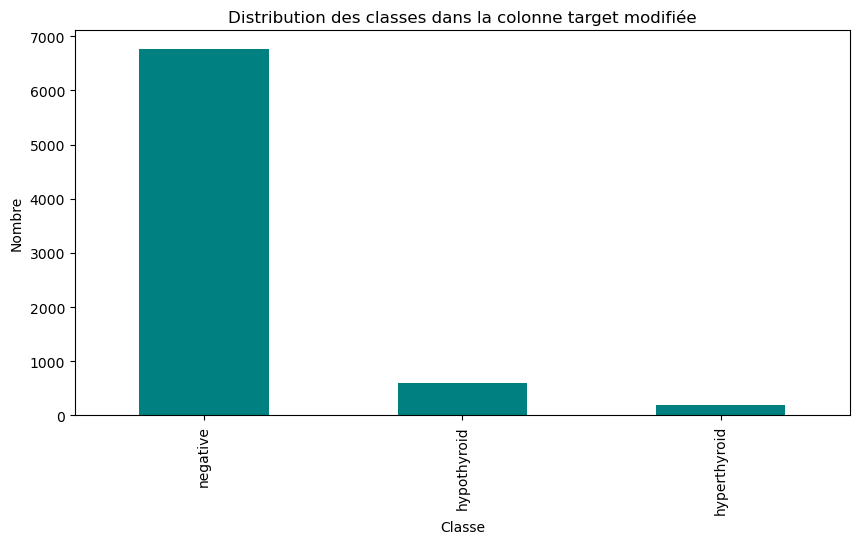

In [14]:
y=data_3class.target

y.value_counts().plot(kind='bar', figsize=(10,5), color='teal')
plt.title("Distribution des classes dans la colonne target modifiée")
plt.xlabel("Classe")
plt.ylabel("Nombre")
plt.show()

On reste dans un cas déséquilibré mais avec moins de classes et moins de bruit, plus facile pour le modèle.

### b. Target version 6 classes
On va aussi créer un second type de target avec 6 classes pour complexifier la prédiction. Afin d’équilibrer le réalisme clinique et la taille des classes, j'ai conservé uniquement les diagnostics présentant un effectif suffisant. Les sous-types hyperthyroïdiens ont été fusionnés, et seules deux formes d’hypothyroïdie (primaire et compensée) ont été conservées. J'ai rajouté plusieurs classes supplémentaires du jeu de données initial qui pouvaient être pertinentes, et j'ai exclu les classes post-diagnostic en lien avec le traitement. 
Ce choix aboutit à un jeu de données à six classes, équilibré et médicalement cohérent. (Voir documentation kaggle)

In [15]:
data_6class = data.copy()

# On mappe les meta-catégories
diagnostics = {'-': 'negative',
             'A': 'hyperthyroid', 
             'B': 'hyperthyroid', 
             'C': 'hyperthyroid', 
             'D': 'hyperthyroid',
             'F': 'primary hypothyroid', 
             'G': 'compensated hypothyroid', 
             'I': 'binding_protein_issue',
             'J': 'binding_protein_issue',
             'K': 'concurrent non-thyroidal illness',
             'R': 'discordant assay results'
             }

data_6class['target'] = data_6class['target'].map(diagnostics)

data_6class.dropna(subset=['target'], inplace=True) # On retire les individus qui ne mappent pas dans les méta-catégories

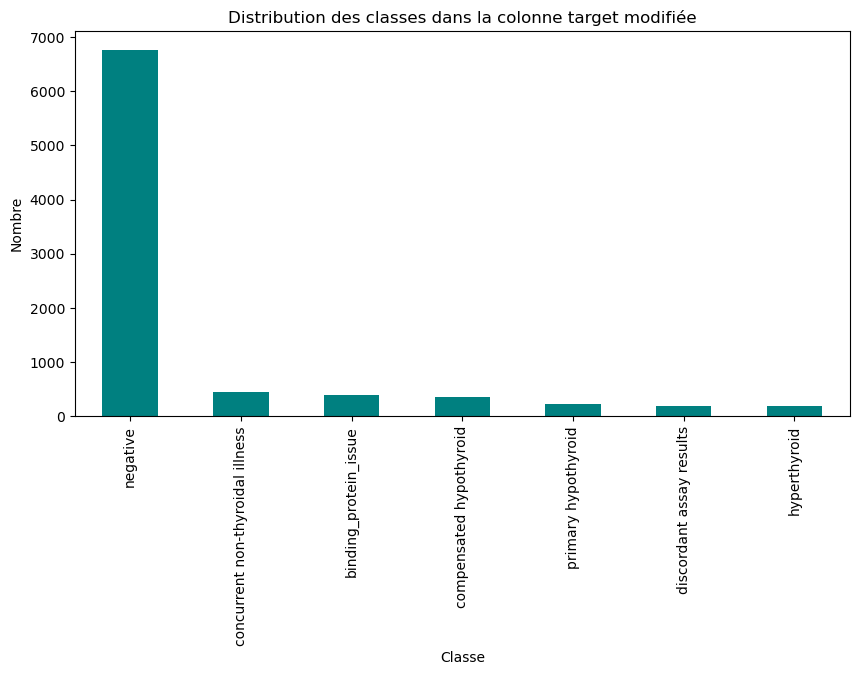

In [16]:
y=data_6class.target

y.value_counts().plot(kind='bar', figsize=(10,5), color='teal')
plt.title("Distribution des classes dans la colonne target modifiée")
plt.xlabel("Classe")
plt.ylabel("Nombre")
plt.show()

On a maintenant + de classes, avec des déséquilibres évidents et surtout des classes avec des biomarqueurs associés probablement différents.

# 2. Premier Modèle, sans Feature Engineering 

J'ai décidé de faire un premier modèle "baseline" avec un Random Forest, pour avoir un point de référence et éventuellement repérer des problèmes qu'il faudra corriger par la suite.

In [17]:
data_3class.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7546 entries, 0 to 9171
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  7542 non-null   float64
 1   sex                  7296 non-null   object 
 2   on_thyroxine         7546 non-null   object 
 3   query_on_thyroxine   7546 non-null   object 
 4   on_antithyroid_meds  7546 non-null   object 
 5   sick                 7546 non-null   object 
 6   pregnant             7546 non-null   object 
 7   thyroid_surgery      7546 non-null   object 
 8   I131_treatment       7546 non-null   object 
 9   query_hypothyroid    7546 non-null   object 
 10  query_hyperthyroid   7546 non-null   object 
 11  lithium              7546 non-null   object 
 12  goitre               7546 non-null   object 
 13  tumor                7546 non-null   object 
 14  hypopituitary        7546 non-null   object 
 15  psych                7546 non-null   object

On remarque une colonne avec beaucoup de Na : la mesure de l'hormone TBG.

In [18]:
data_3class['TBG'].isna().mean()

np.float64(0.9656771799628943)

Cette colonne a presque 97% de valeurs manquantes, donc pour ce premier modèle je la retire. Je choisis ensuite de retirer les lignes où il y a des valeurs manquantes (plus pratique pour un premier modèle baseline). 

In [19]:
data_baseline = data_3class.drop(columns=['TBG'])
data_baseline = data_baseline.dropna()

print(data_baseline.shape)

(4656, 22)


On garde 4659 individus pour le modèle baseline, ce qui est suffisant pour un premier modèle. Evidemment, si il y a une corrélation entre la variable target et les occurences de Na, on le verra plus tard et on verra comment le gérer.

## A. Modèle baseline RandomForest brut : 

Attention, on est dans le cadre de classes déséquilibrées, on ne peut pas se baser uniquement sur l'accuracy.

De plus, ces premiers modèles sont réalisés sur l'ensemble du dataset, à titre informatif. Je ne me sers pas des résultats pour faire du feature sélection ou autre méthode pouvant induire du data leakage.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split X,y
X=data_baseline.drop(columns=["target"])
y=data_baseline.target

# Split variables catégorielles / variables numériques 
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

# Split train test
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # on conserve la même proportion de classes avec stratify

# Preprocessing simple
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# premier modele
pipe=Pipeline([
    ('preprocess_catcol',preprocess),
    ('random_forest',RandomForestClassifier(random_state=42))
    ])

# Entraînement
pipe.fit(X_train,y_train)
y_hat=pipe.predict(X_test)

# Evaluation
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

hyperthyroid       0.81      0.74      0.77        23
 hypothyroid       0.97      1.00      0.99        75
    negative       0.99      0.99      0.99       834

    accuracy                           0.99       932
   macro avg       0.93      0.91      0.92       932
weighted avg       0.99      0.99      0.99       932



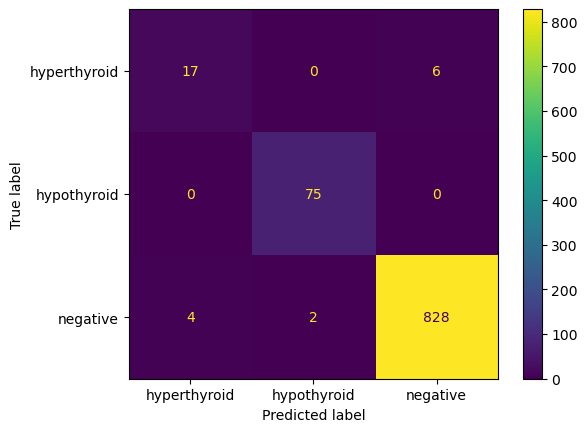

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_hat, labels=pipe.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe.classes_)

disp.plot()

On a déjà de très bons résultats ! Ici on regarde surtout les métriques par classe (précision, recall) et pour le modèle on regardera F1-macro qui est une bonne métrique pour les datasets déséquilibrés (ici on a 0.92). Le modèle a juste un peu plus de mal à détecter l'hyperthyroïdie avec un recall à 0.74 mais le reste est très bon. 

C'est maintenant qu'on se questionne sur le data leakage et les variables post-diagnostic. 
=> On retire ces variables "post-diagnostic" pour voir...

## B. Modèle baseline RandomForest sans 'leakage features' : 

In [24]:
leakage_features = [
    'on_thyroxine',
    'query_on_thyroxine',
    'on_antithyroid_meds',
    'thyroid_surgery',
    'I131_treatment',
    'query_hypothyroid',
    'query_hyperthyroid'
]

data_baseline2=data_baseline.drop(columns=leakage_features)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split X,y
X=data_baseline2.drop(columns=["target"])
y=data_baseline2.target

# Split variables catégorielles / variables numériques 
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

# Split train test
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # on conserve la même proportion de classes avec stratify

# Preprocessing simple
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# premier modele
pipe=Pipeline([
    ('preprocess_catcol',preprocess),
    ('random_forest',RandomForestClassifier(random_state=42))
    ])

# Entraînement
pipe.fit(X_train,y_train)
y_hat=pipe.predict(X_test)

# Evaluation
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

hyperthyroid       0.80      0.70      0.74        23
 hypothyroid       0.97      1.00      0.99        75
    negative       0.99      0.99      0.99       834

    accuracy                           0.99       932
   macro avg       0.92      0.90      0.91       932
weighted avg       0.99      0.99      0.99       932



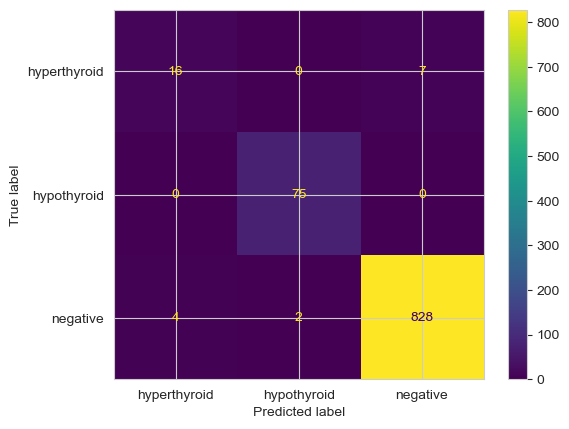

In [386]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_hat, labels=pipe.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe.classes_)

disp.plot()

Le modèle conserve une F1-macro de 0.91 ! Les métriques de la classe hyperthyroid notamment, diminuent aussi. Mais on n'observe pas non plus de très large diminution des métriques. 
Cela indique que les très bons résultats observés ne proviennent pas d’un effet de data leakage, mais plutôt du fort pouvoir explicatif des variables biologiques (TSH, T3, TT4, FTI…) directement liées au diagnostic médical.
On va quand même retirer les variables obtenues post-diagnostic dans la suite du projet, dans un souci de cohérence médicale.

Maintenant, essayons d'enlever les variables biologiques (taux d'hormones).

## C. Modèle baseline RandomForest sans 'leakage features' & sans variables biologiques : 

In [26]:
variables_hormones = [
    'TSH', 'T3', 'TT4', 'T4U', 'FTI'
]

data_baseline3=data_baseline.drop(columns=variables_hormones)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split X,y
X=data_baseline3.drop(columns=["target"])
y=data_baseline3.target

# Split variables catégorielles / variables numériques 
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

# Split train test
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # on conserve la même proportion de classes avec stratify

# Preprocessing simple
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# premier modele
pipe=Pipeline([
    ('preprocess_catcol',preprocess),
    ('random_forest',RandomForestClassifier(random_state=42))
    ])

# Entraînement
pipe.fit(X_train,y_train)
y_hat=pipe.predict(X_test)

# Evaluation
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

hyperthyroid       0.17      0.09      0.11        23
 hypothyroid       0.17      0.03      0.05        75
    negative       0.90      0.98      0.93       834

    accuracy                           0.88       932
   macro avg       0.41      0.36      0.36       932
weighted avg       0.82      0.88      0.84       932



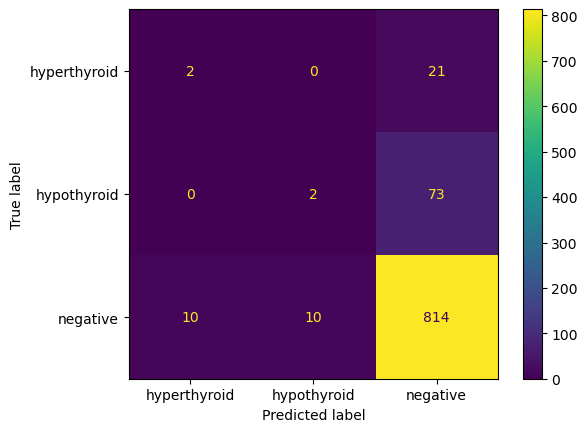

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_hat, labels=pipe.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe.classes_)

disp.plot()

Sans les variables biologiques (TSH, T3, TT4, T4U, FTI), les performances chutent fortement : les métriques des classes minoritaires s'effondrent mais l'accuracy reste haute : le modèle se contente de prédire la classe dominante.


**Discussion :**
Au vu des très bons résultats sur le modèle baseline, on va maintenant regarder si le modèle est toujours aussi bon avec + de classes. On va maintenant tester le modèle baseline sur la subdivision en 6 classes de target.

### D. Modèle baseline RandomForest sans 'leakage features' sur 6 classes : 

Voyons si notre baseline model est capable de discriminer les 6 classes.

In [29]:
data_baseline4 = data_6class.drop(columns=['TBG'])
data_baseline4.dropna(inplace=True)

data_baseline4.drop(columns=leakage_features,axis=1,inplace=True)

print(data_baseline4.shape)

data_baseline4['target'].value_counts()


(5439, 15)


target
negative                            4165
concurrent non-thyroidal illness     406
binding_protein_issue                225
compensated hypothyroid              211
primary hypothyroid                  164
discordant assay results             152
hyperthyroid                         116
Name: count, dtype: int64

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split X,y
X=data_baseline4.drop(columns=["target"])
y=data_baseline4.target

# Split variables catégorielles / variables numériques 
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

# Split train test
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # on conserve la même proportion de classes avec stratify

# Preprocessing simple
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# premier modele
pipe=Pipeline([
    ('preprocess_catcol',preprocess),
    ('random_forest',RandomForestClassifier(random_state=42))
    ])

# Entraînement
pipe.fit(X_train,y_train)
y_hat=pipe.predict(X_test)

# Evaluation
print(classification_report(y_test, y_hat))

                                  precision    recall  f1-score   support

           binding_protein_issue       0.79      0.58      0.67        45
         compensated hypothyroid       0.93      0.98      0.95        42
concurrent non-thyroidal illness       0.78      0.93      0.85        81
        discordant assay results       0.78      0.81      0.79        31
                    hyperthyroid       0.76      0.83      0.79        23
                        negative       0.96      0.95      0.96       833
             primary hypothyroid       0.97      0.94      0.95        33

                        accuracy                           0.93      1088
                       macro avg       0.85      0.86      0.85      1088
                    weighted avg       0.93      0.93      0.93      1088



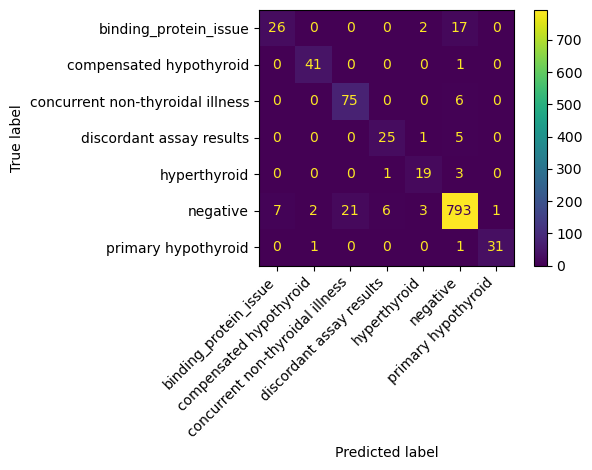

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_hat, labels=pipe.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe.classes_)

disp.plot(cmap="viridis", values_format=".0f")  
plt.xticks(rotation=45, ha='right')           # rotation des labels axe X
plt.yticks(rotation=0)                        # labels axe Y restent droits
plt.tight_layout()                            # évite que les labels dépassent
plt.show()

La classification en six catégories obtient de bonnes performances globales, avec une F1-macro de 0.85. Le modèle distingue très efficacement les situations les plus courantes et bien définies biologiquement, notamment les cas négatifs (F1 = 0.96) ainsi que les hypothyroïdies primaire et compensée (F1 ≈ 0.95). Cela confirme le fort pouvoir discriminant des marqueurs hormonaux (TSH, T3, T4, FTI) et la capacité du modèle à reproduire les logiques diagnostiques classiques.

Les classes plus rares et/ou moins nettes cliniquement restent plus difficiles à prédire, en particulier les anomalies de protéines de liaison (F1 = 0.67) et certaines formes d’hyperthyroïdie ou discordances analytiques (F1 ~ 0.79). Ces limites s’expliquent surtout par le déséquilibre des classes et la nature subtile de ces diagnostics.

Globalement, le modèle montre une bonne robustesse, tout en laissant une marge d’amélioration pour mieux gérer les classes minoritaires.

# 3. Analyse des Données
On va regarder les liens variables - target pour avoir une idée des variables importantes et réfléchir au feature engineering pour les modèles finaux.

On drop définitivement les leakage feature, qui ne sont pas cohérentes médicalement car obtenues post-diagnostic (notre target).

In [32]:
data_3class.drop(columns=leakage_features,axis=1,inplace=True)
data_6class.drop(columns=leakage_features,axis=1,inplace=True)

### a. Target 3 classes

In [33]:
data_3class.columns

Index(['age', 'sex', 'sick', 'pregnant', 'lithium', 'goitre', 'tumor',
       'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG',
       'target'],
      dtype='object')

<Axes: xlabel='target', ylabel='age'>

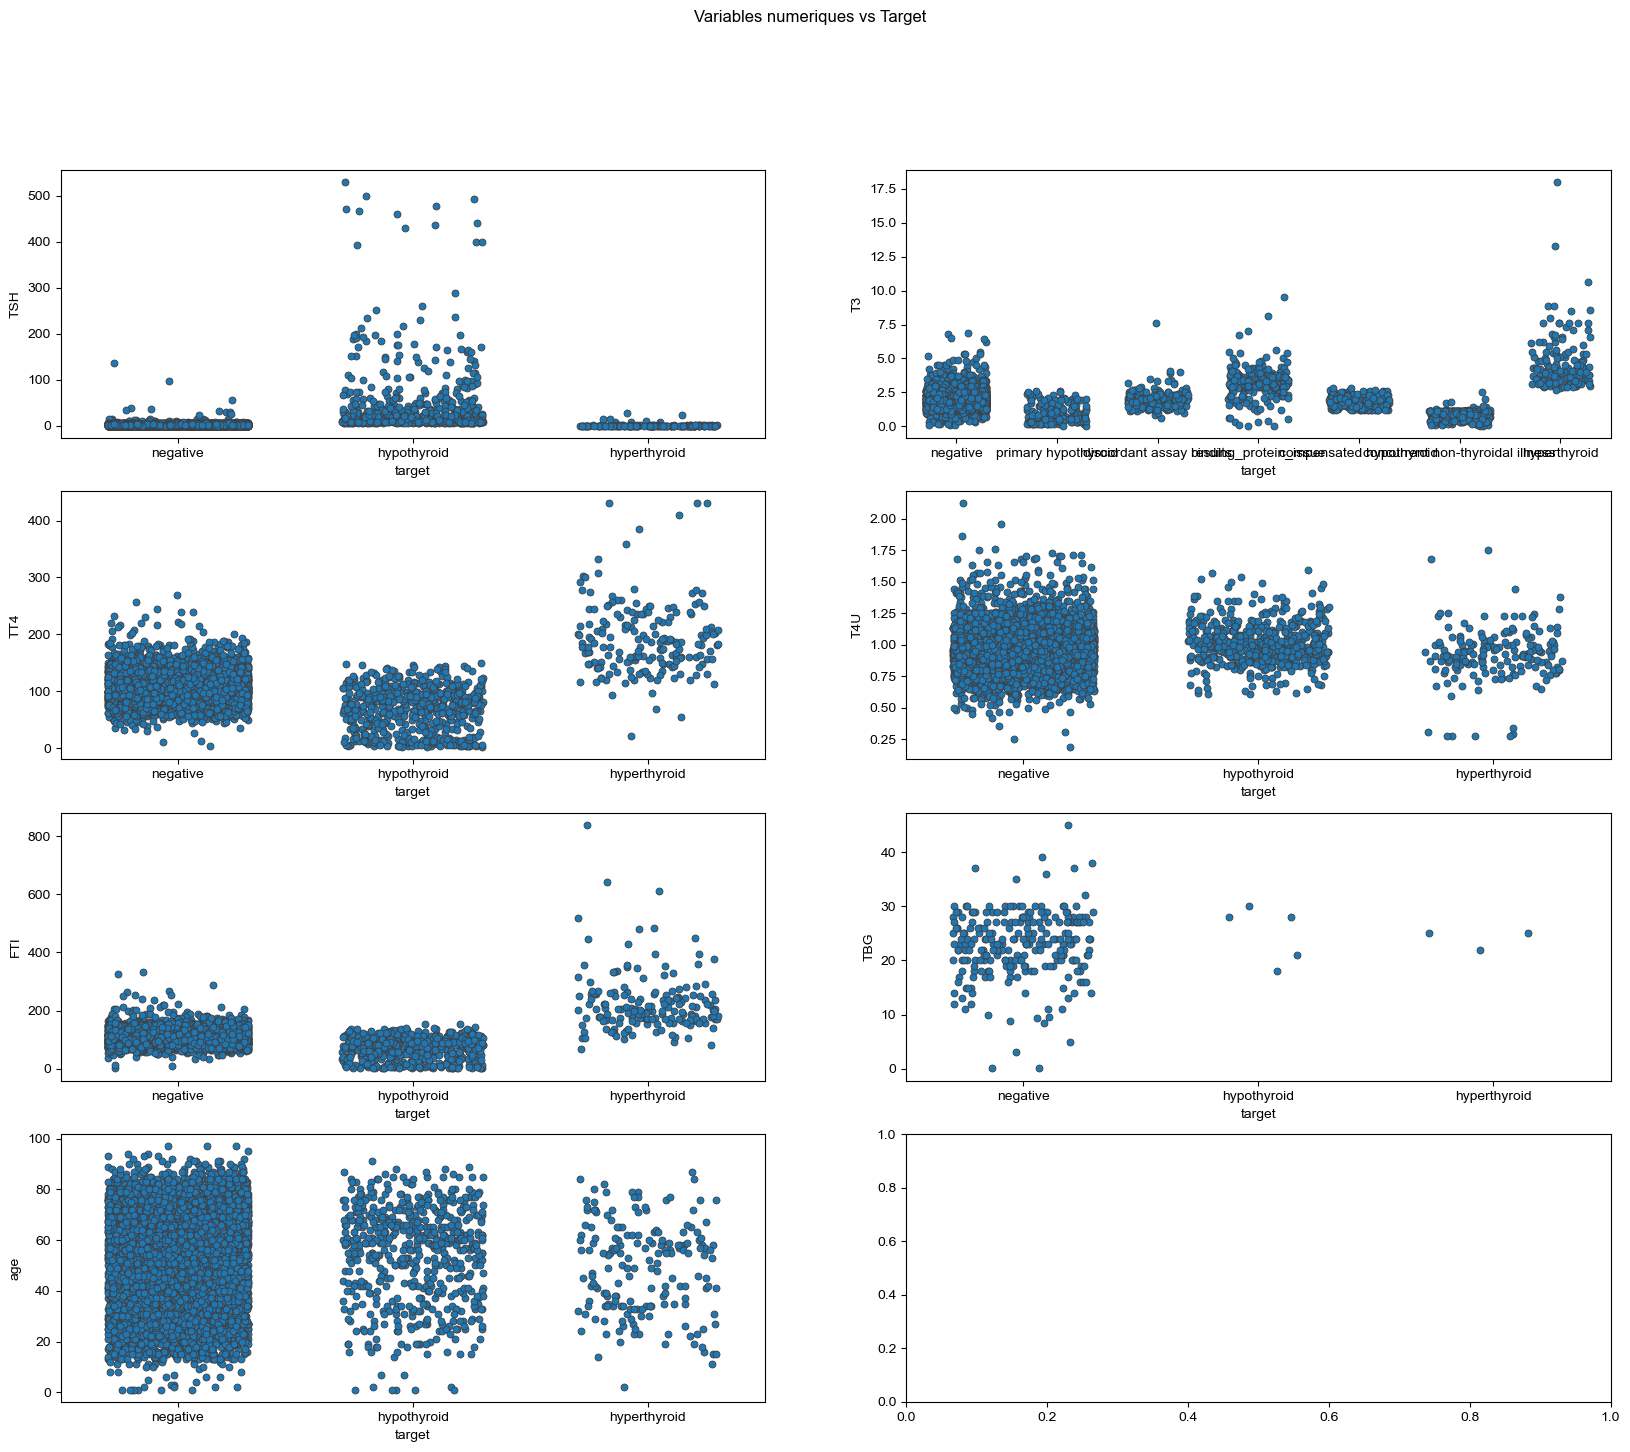

In [35]:
import seaborn as sns
# plusieurs plots en grid
fig, axes = plt.subplots(4,2,figsize=(20,16))
fig.suptitle('Variables numeriques vs Target')
sns.set_style('whitegrid')

# TSH vs 'target'
sns.stripplot(x=data_3class.target, y=data_3class.TSH, linewidth=0.6, jitter= 0.3, ax=axes[0, 0])
# T3 vs 'target'
sns.stripplot(x=data_6class.target, y=data_6class.T3, linewidth=0.6, jitter= 0.3, ax=axes[0, 1])
# TT4 vs 'target'
sns.stripplot(x=data_3class.target, y=data_3class.TT4, linewidth=0.6, jitter= 0.3, ax=axes[1, 0])
# T4U vs 'target'
sns.stripplot(x=data_3class.target, y=data_3class.T4U, linewidth=0.6, jitter= 0.3, ax=axes[1, 1])
# FTI vs 'target'
sns.stripplot(x=data_3class.target, y=data_3class.FTI, linewidth=0.6, jitter= 0.3, ax=axes[2, 0])
# TBG vs 'target'
sns.stripplot(x=data_3class.target, y=data_3class.TBG, linewidth=0.6, jitter= 0.3, ax=axes[2, 1])
# Age vs 'target'
sns.stripplot(x=data_3class.target, y=data_3class.age, linewidth=0.6, jitter= 0.3, ax=axes[3, 0])


On observe déjà ici des relations entre le taux de certaines hormones et le diagnostic. Par contre l'âge ne semble pas discriminer la pathologie sur 3 classes.

<Axes: >

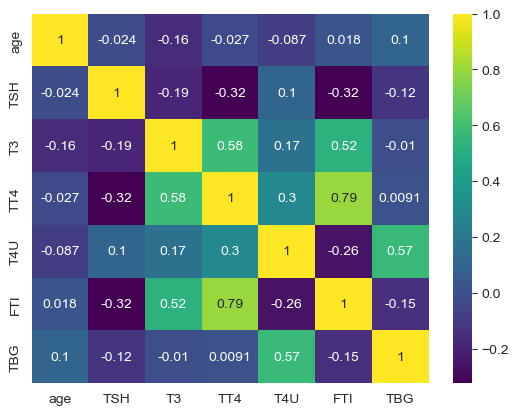

In [36]:
import seaborn as sns
num_cols = data_3class.select_dtypes(exclude='object').columns
sns.heatmap(data_3class[num_cols].corr(), annot=True, cmap="viridis")

On retrouve globalement les liens biologiques attendus entre les hormones : 
- TSH diminue quand T4/T3 augmente, TSH augmente quand T4/T3 diminue (anticorrélés : feedback négatif sur l'axe hypothalamo-hypophysaire) 
- TT4 (forme précurseur) se transforme en T3 (forme active) (corrélation positive, sauf cas particuliers/pathologies) 
- T4U est inverse du taux de TBG => ici NON ! probablement un artefact statistique dû au manque de données (97% de NA pour cette colonne => pas utilisable, on en retrouve pas les liens physiologiques pour cette hormone) 
- FTI = TT4 × T4U (FTI : TT4 "vraiment" disponible => + fiable) : d'où la corrélation positive FTI - TT4, cependant le T4U est faiblement anti-corrélé à FTI ??? (T4U agit comme facteur de correction lié au transport des hormones thyroïdiennes, et non à leur production => T4U peut varier en sens inverse de TT4 dans certains contextes physiologiques ou démographiques)

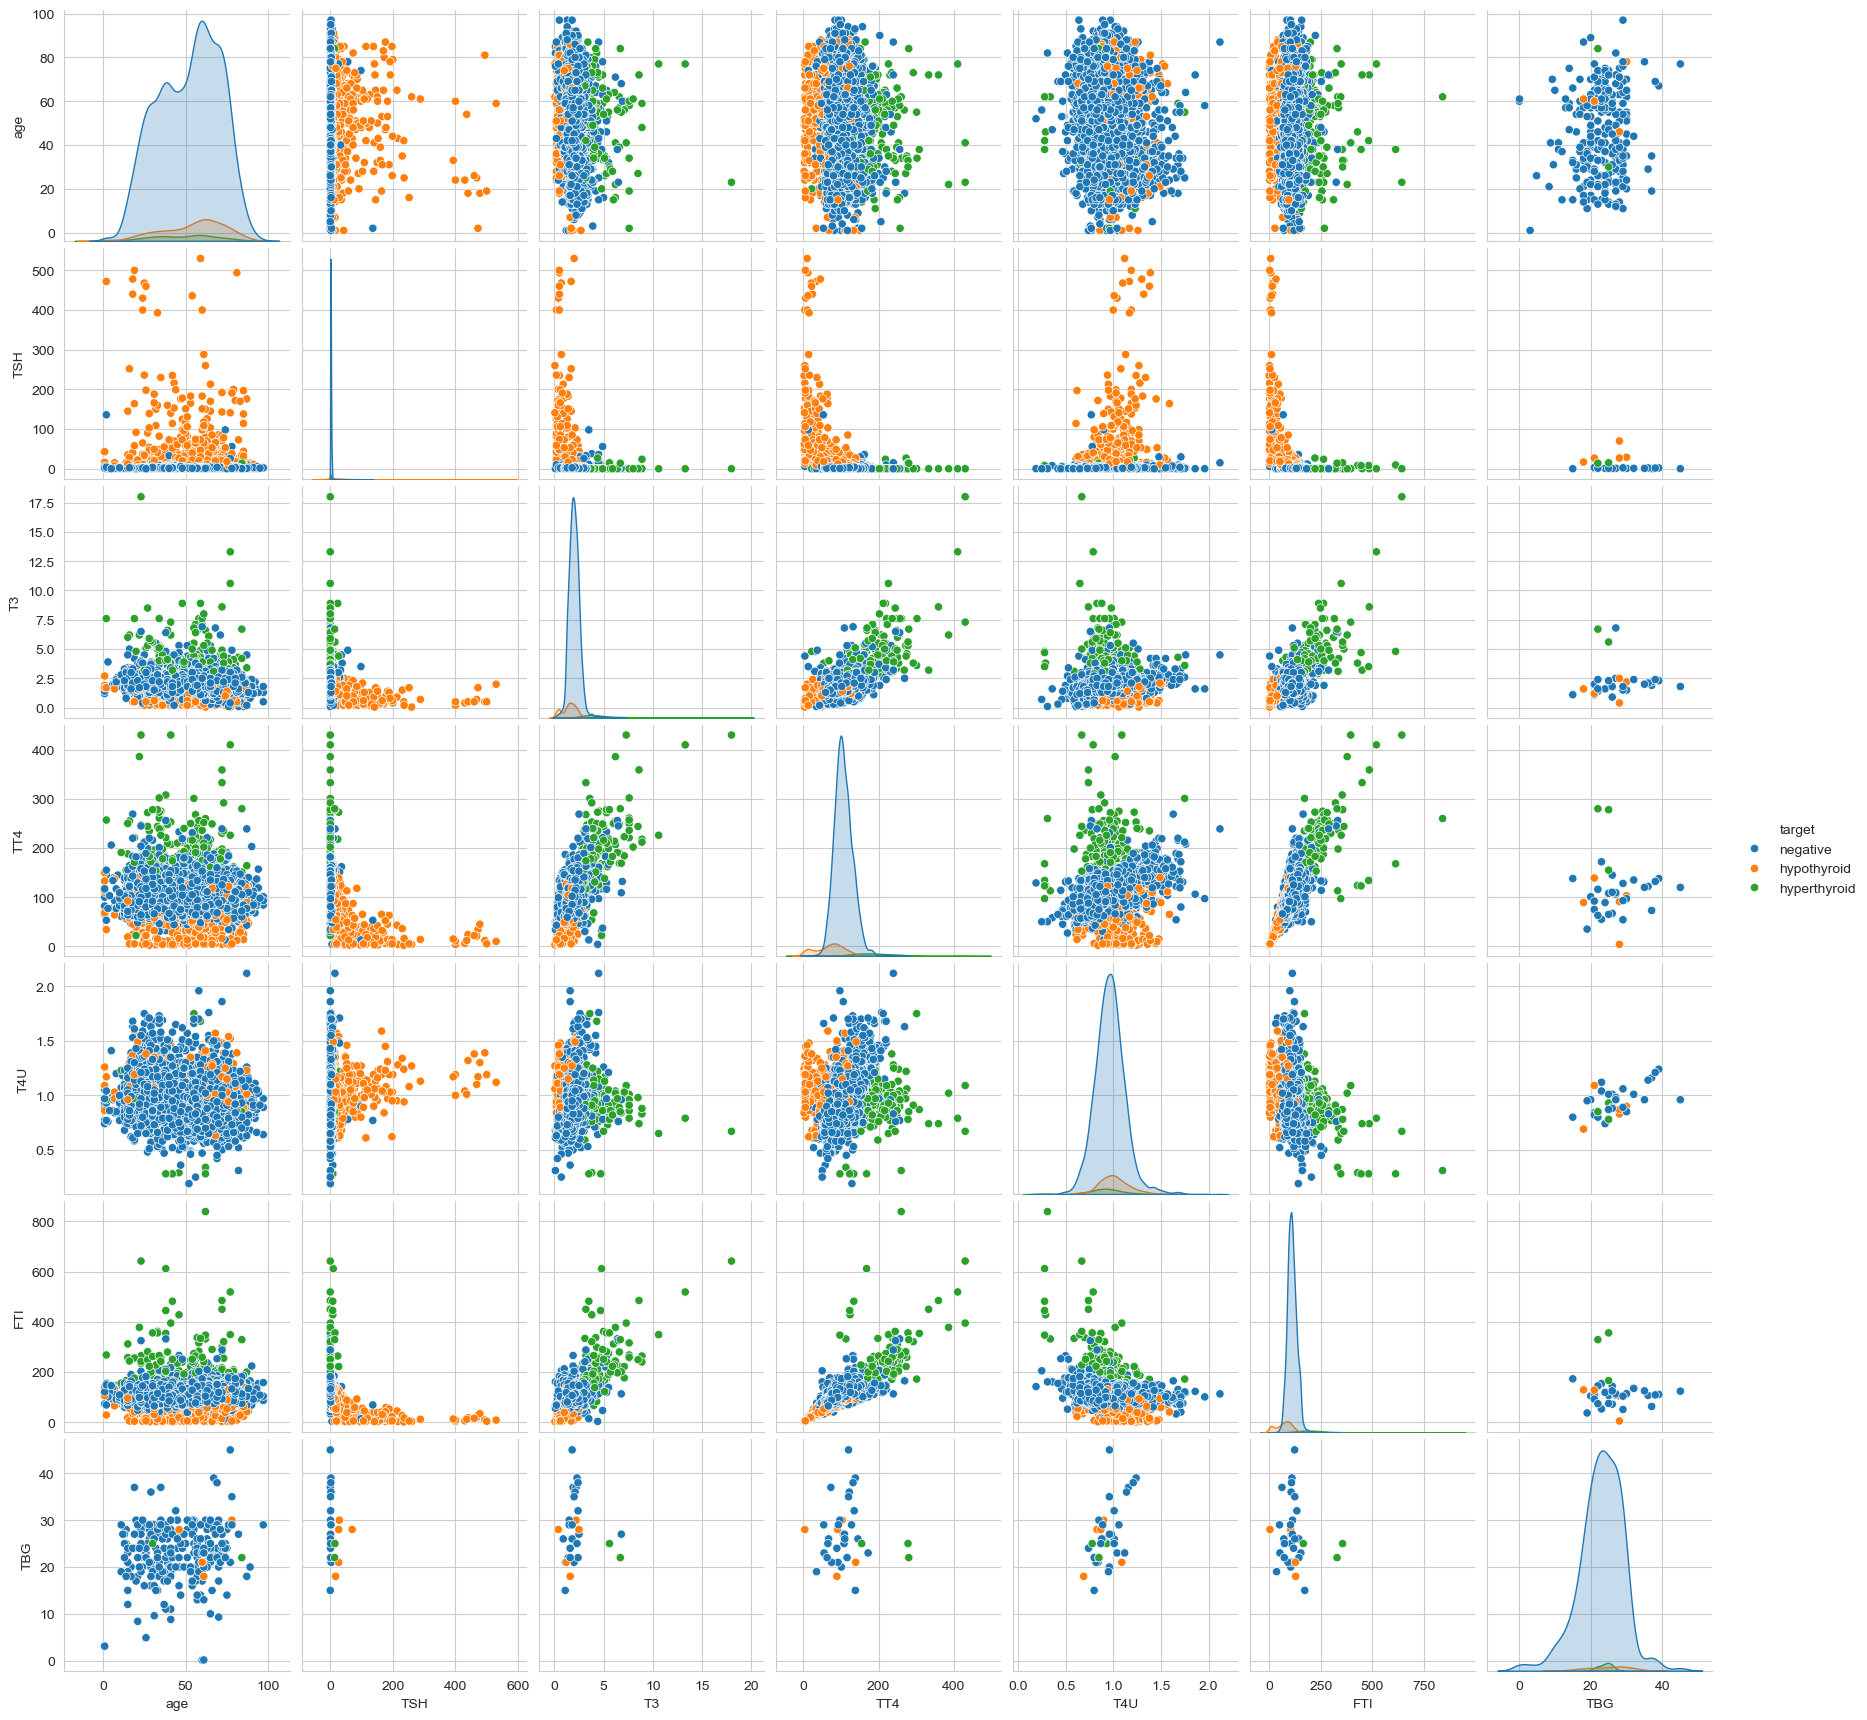

In [37]:
sns.pairplot(data_3class, vars=['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI','TBG'], hue="target")

On observe déjà une forte structure naturelle dans les données ! 

On va calculer le Mutual Information : cela va permettre de nous confirmer les features les plus importantes dans nos données. 

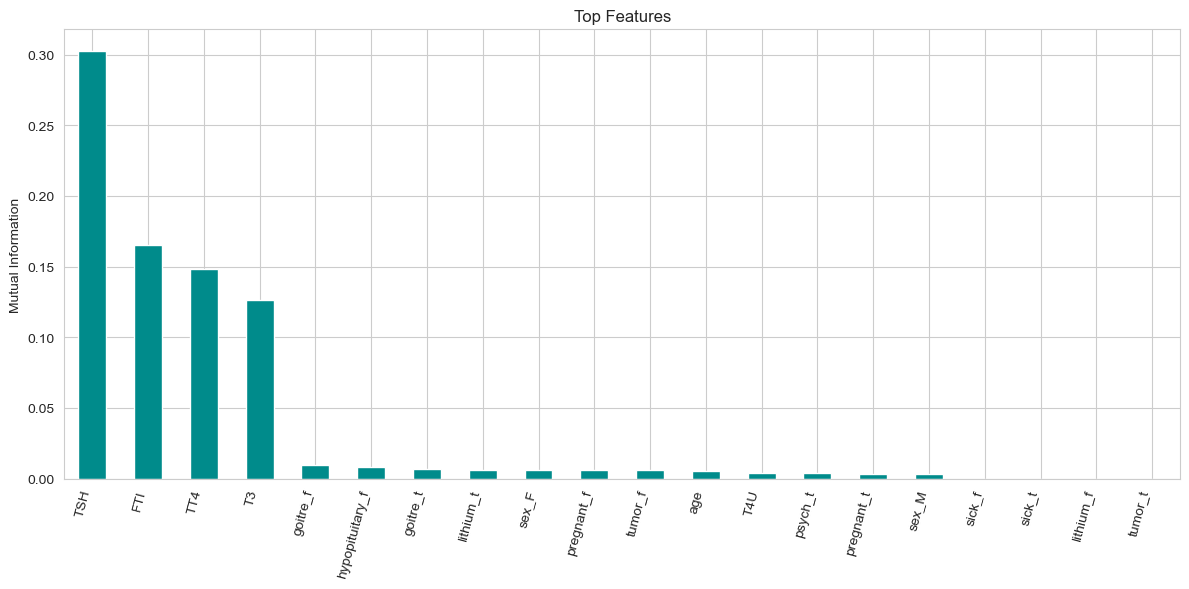

TSH                0.302638
FTI                0.165264
TT4                0.148569
T3                 0.126089
goitre_f           0.009553
hypopituitary_f    0.007896
goitre_t           0.006588
lithium_t          0.006143
sex_F              0.005883
pregnant_f         0.005798
tumor_f            0.005787
age                0.005675
T4U                0.004125
psych_t            0.004049
pregnant_t         0.003168
sex_M              0.002978
sick_f             0.000000
sick_t             0.000000
lithium_f          0.000000
tumor_t            0.000000
dtype: float64

In [38]:
# Mutual information
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer

# drop na
df=data_3class.drop(columns=["TBG"]).copy()
df.dropna(inplace=True)

# cat / num
cat_cols = df.select_dtypes(include='object').drop(columns=['target']).columns.tolist()
num_cols = df.select_dtypes(exclude='object').columns.tolist()


X = df[num_cols + cat_cols]
y = df['target']

# encode targets
le = LabelEncoder()
y_enc = le.fit_transform(y)

# onehot categoriel
ct = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
], remainder='passthrough')

X_enc = ct.fit_transform(X)

#nom colonnes
cat_feature_names = ct.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_feature_names = list(cat_feature_names) + num_cols  # numériques à la fin

mi = mutual_info_classif(X_enc, y_enc, random_state=42)
mi_series = pd.Series(mi, index=all_feature_names).sort_values(ascending=False)

# --- Plot ---
plt.figure(figsize=(12,6))
mi_series.head(20).plot(kind='bar', color='darkcyan')
plt.title("Top Features")
plt.ylabel("Mutual Information")
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

mi_series.head(20)



L’analyse de l'information mutuelle confirme que les biomarqueurs hormonaux portent l’essentiel de l’information prédictive, en particulier la TSH, suivie de la FTI, de la TT4 et de la T3.
Les variables cliniques (goitre, hypothypophyse, lithium, sexe, grossesse) contribuent marginalement, ce qui est cohérent avec leur rôle indirect.


/Users/mafaldafrere/miniforge3/envs/env_numpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mafaldafrere/miniforge3/envs/env_numpy/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


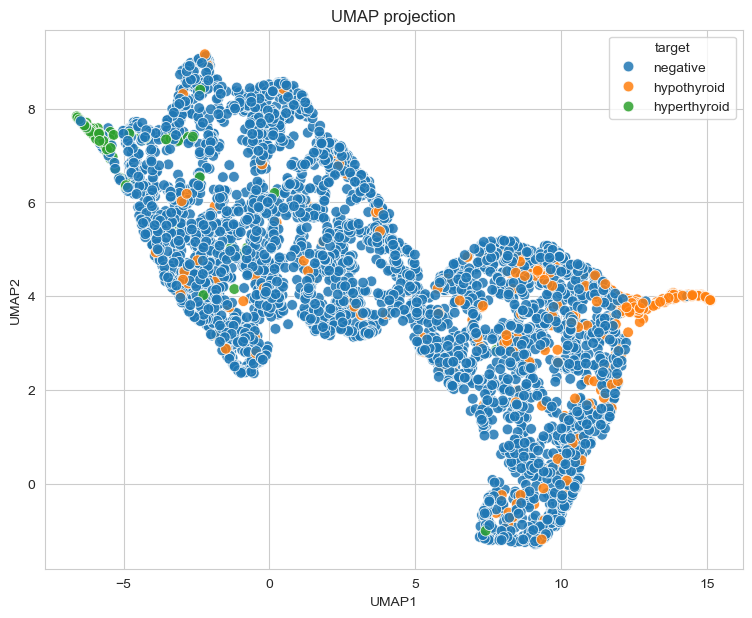

In [39]:
# visu umap 

import umap

embedding = umap.UMAP(random_state=42).fit_transform(X_enc)

umap_df = pd.DataFrame(embedding, columns=['UMAP1','UMAP2'])
umap_df['target'] = y.values

plt.figure(figsize=(9,7))
sns.scatterplot(
    data=umap_df,
    x='UMAP1', y='UMAP2',
    hue='target',
    palette="tab10",
    s=60, alpha=0.85
)
plt.title("UMAP projection")
plt.show()

La majorité des patients négatifs (bleu) forment une masse diffuse ce qui est normal, la population générale est hétérogène. Les hypothyroïdiens (orange) forment un bras clair à droite. Effectivement physiologiquement, leur TSH est haute, c'est un pattern stable. Les hyperthyroïdiens (vert) sont un peu + répartis, c'est normal, ils sont plus rares avec des phénotypes + variés. 

=> Sur la cible avec 3 classes, les données ont une structure naturelle très forte. 

## B. Target 6 class

<Axes: xlabel='target', ylabel='age'>

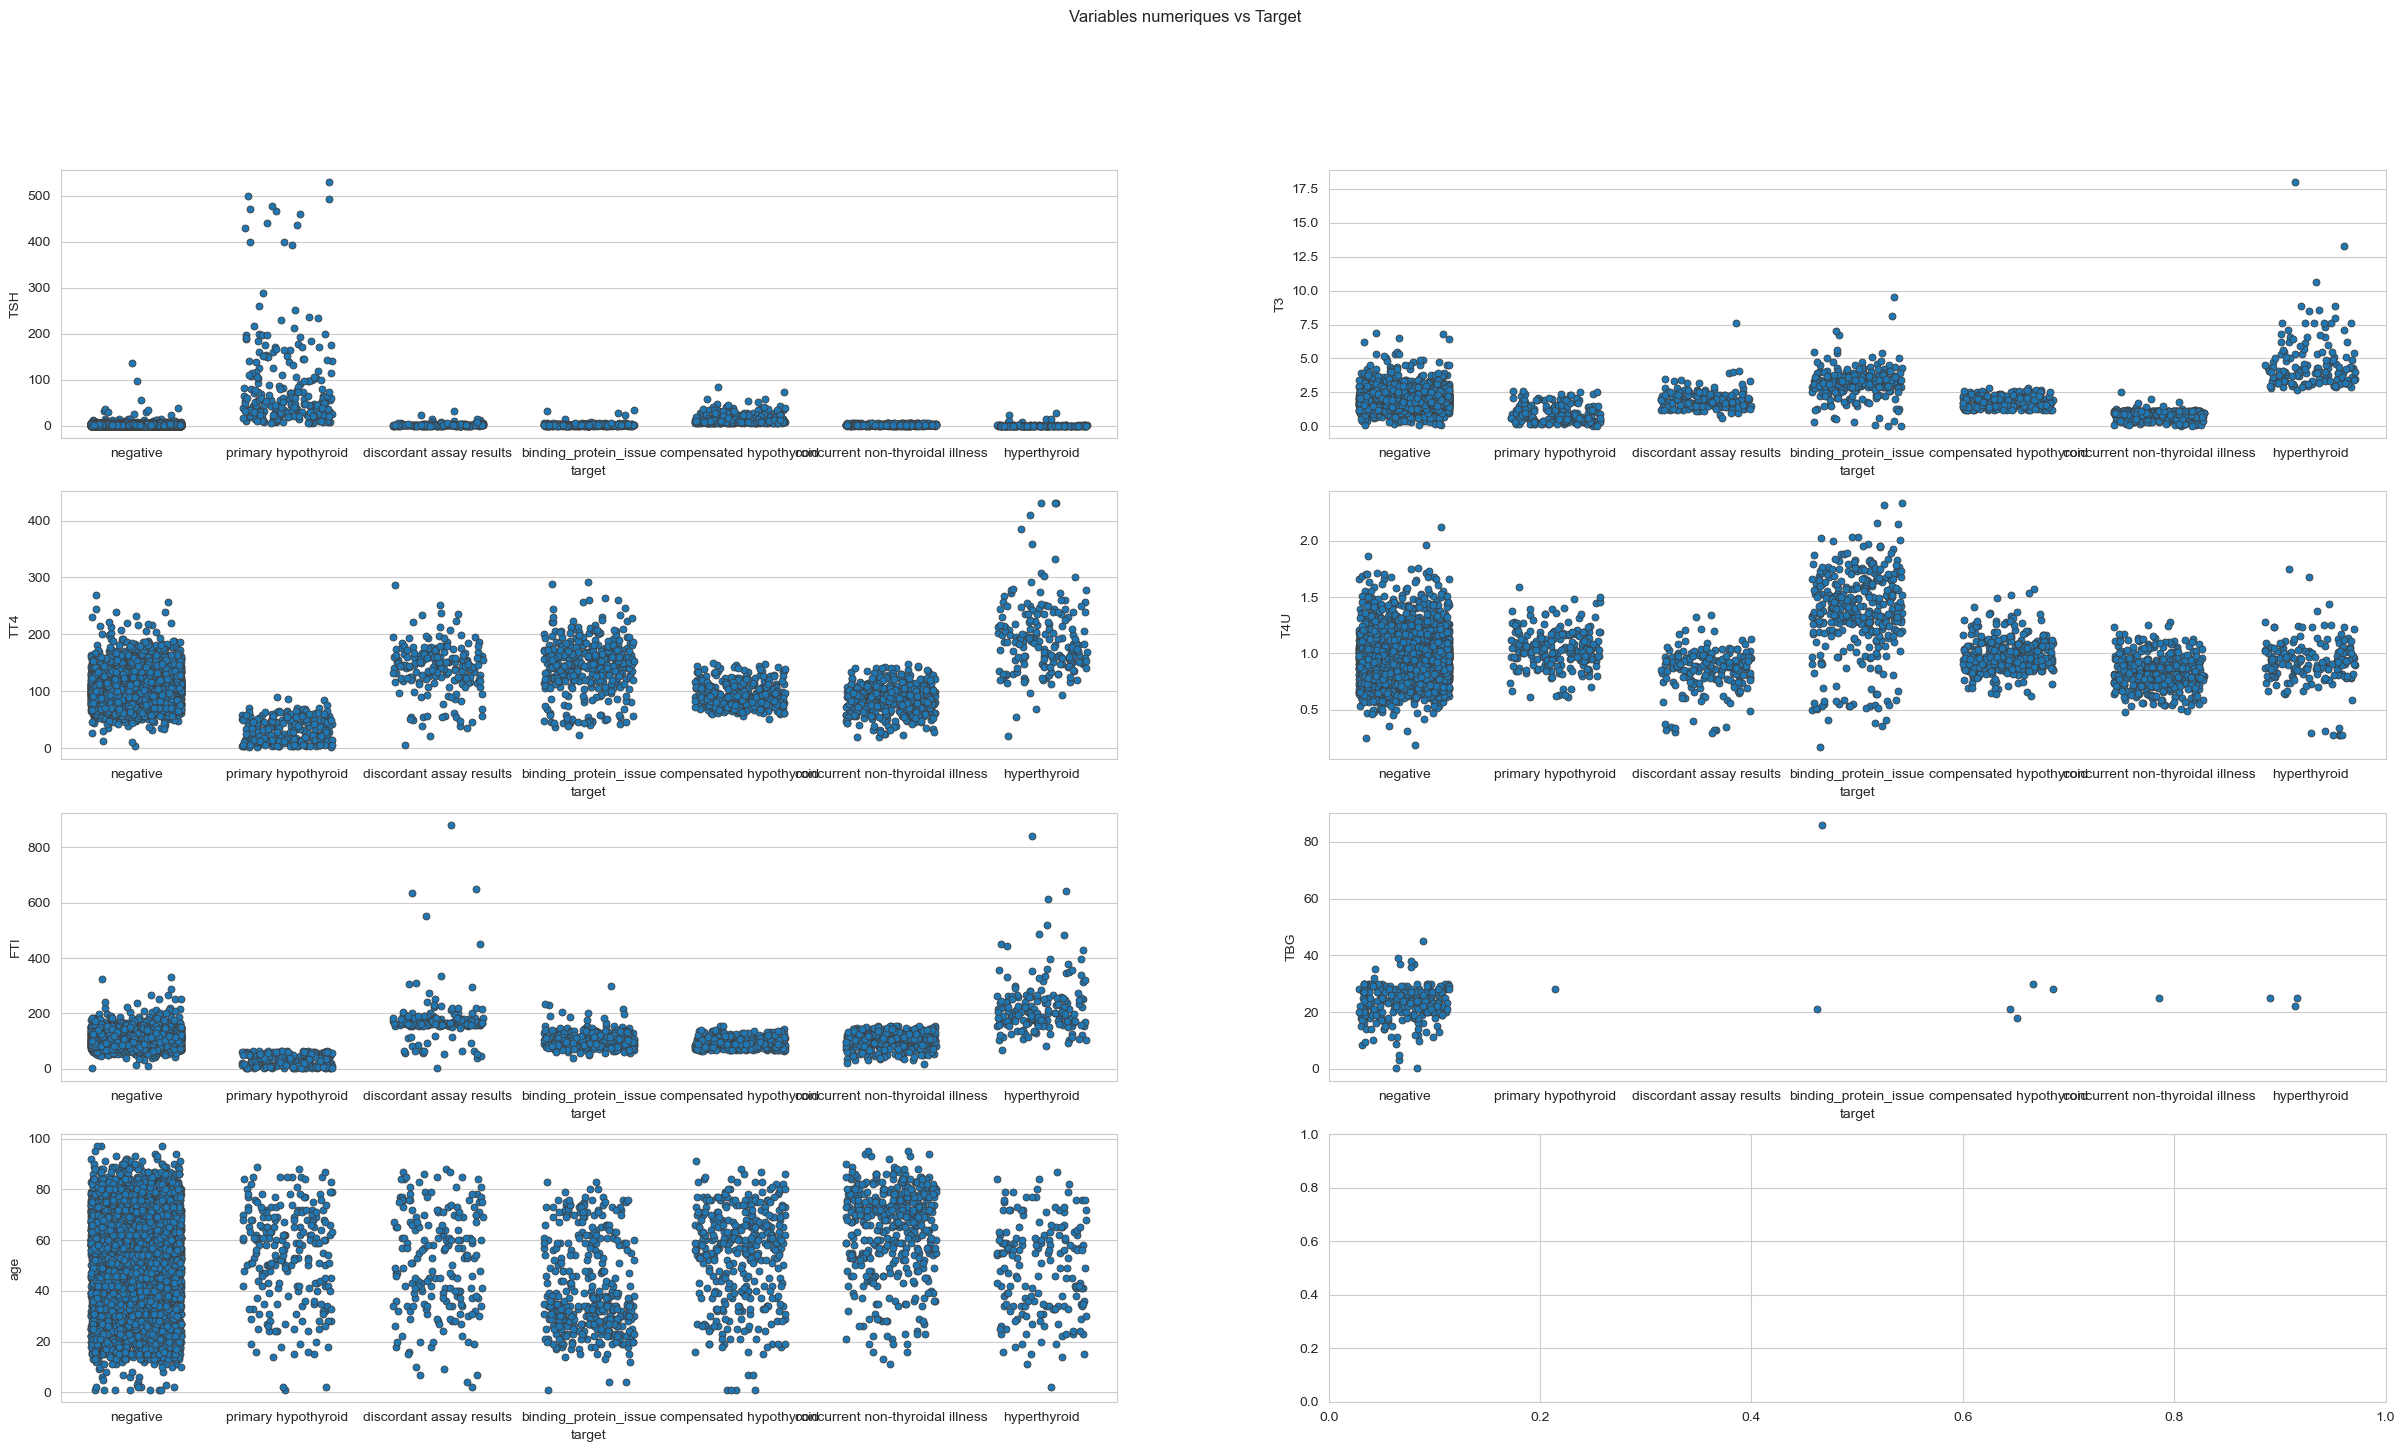

In [40]:
# plusieurs plots en grid
fig, axes = plt.subplots(4,2,figsize=(30,16))
fig.suptitle('Variables numeriques vs Target')
sns.set_style('whitegrid')

# TSH vs 'target'
sns.stripplot(x=data_6class.target, y=data_6class.TSH, linewidth=0.6, jitter= 0.3, ax=axes[0, 0])
# T3 vs 'target'
sns.stripplot(x=data_6class.target, y=data_6class.T3, linewidth=0.6, jitter= 0.3, ax=axes[0, 1])
# TT4 vs 'target'
sns.stripplot(x=data_6class.target, y=data_6class.TT4, linewidth=0.6, jitter= 0.3, ax=axes[1, 0])
# T4U vs 'target'
sns.stripplot(x=data_6class.target, y=data_6class.T4U, linewidth=0.6, jitter= 0.3, ax=axes[1, 1])
# FTI vs 'target'
sns.stripplot(x=data_6class.target, y=data_6class.FTI, linewidth=0.6, jitter= 0.3, ax=axes[2, 0])
# TBG vs 'target'
sns.stripplot(x=data_6class.target, y=data_6class.TBG, linewidth=0.6, jitter= 0.3, ax=axes[2, 1])
# Age vs 'target'
sns.stripplot(x=data_6class.target, y=data_6class.age, linewidth=0.6, jitter= 0.3, ax=axes[3, 0])


Toutes les hormones semblent importantes pour discriminer les 6 classes. (Sauf TBG : trop de Na.) L'âge semble jouer un rôle + important chez les 6 classes, notamment pour les classes "binding protein issue", "compensated hypothyroid" et "concurrent non-thyroidal illness" où la distribution est particulière.

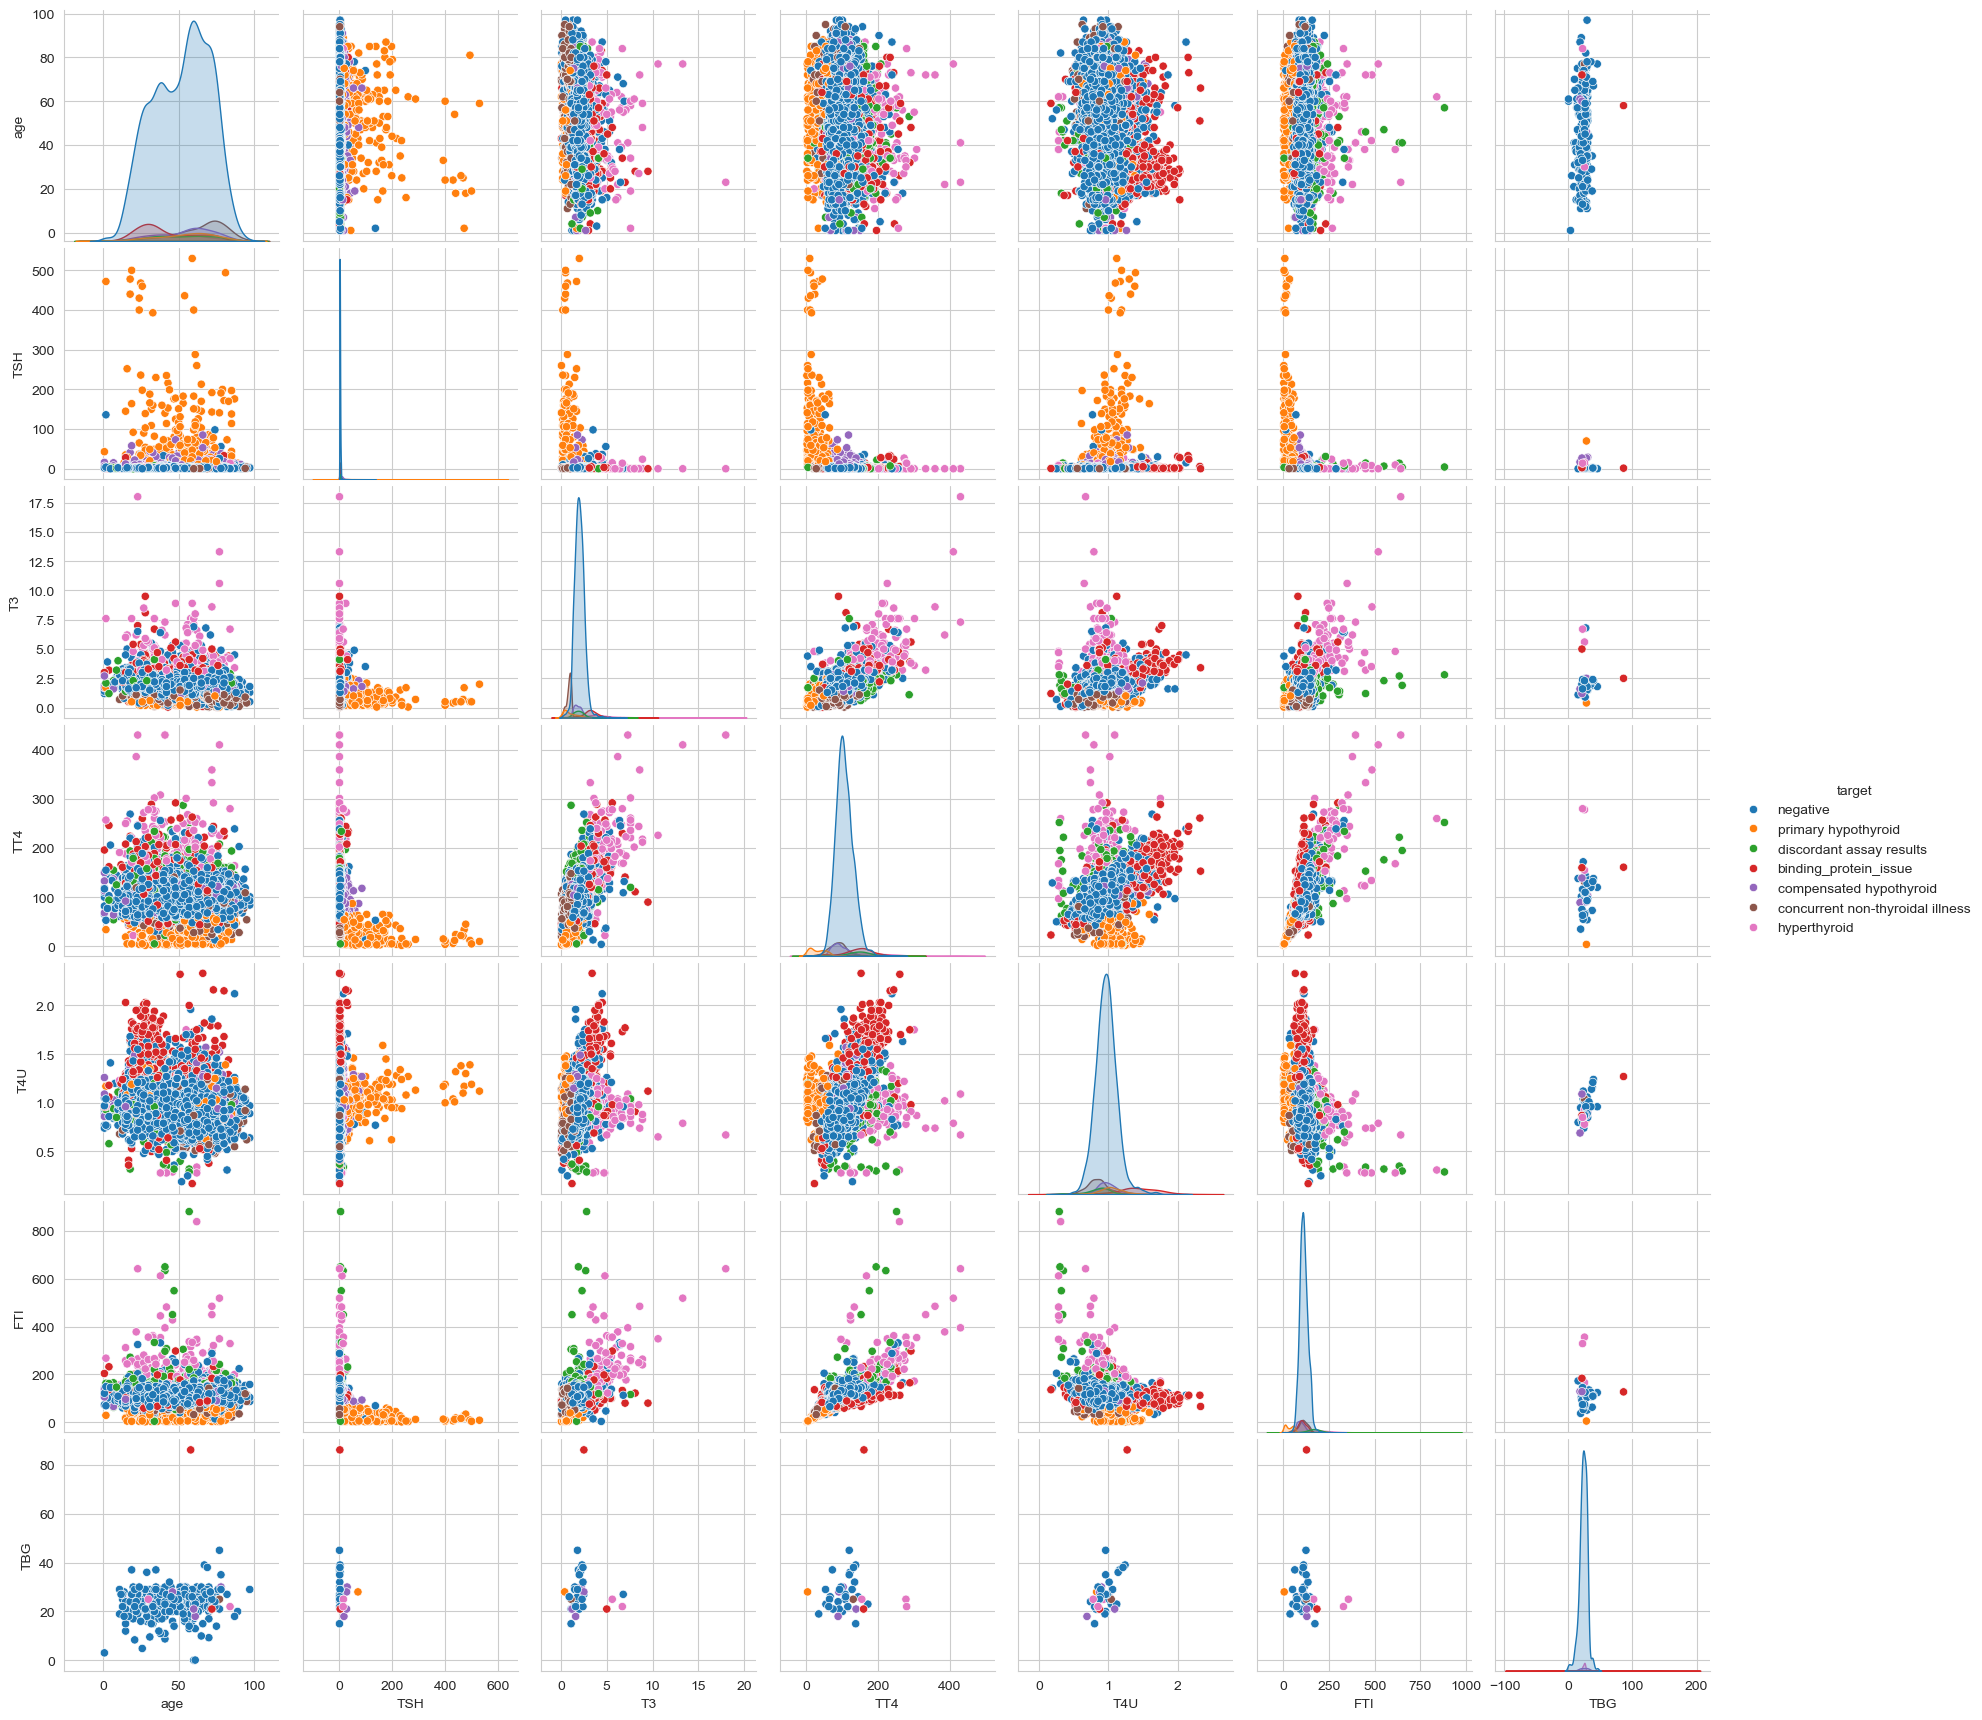

In [41]:
sns.pairplot(data_6class, vars=['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI','TBG'], hue="target")

On observe des clusters pour nos classes (un peu diffus, mais quand même observables).

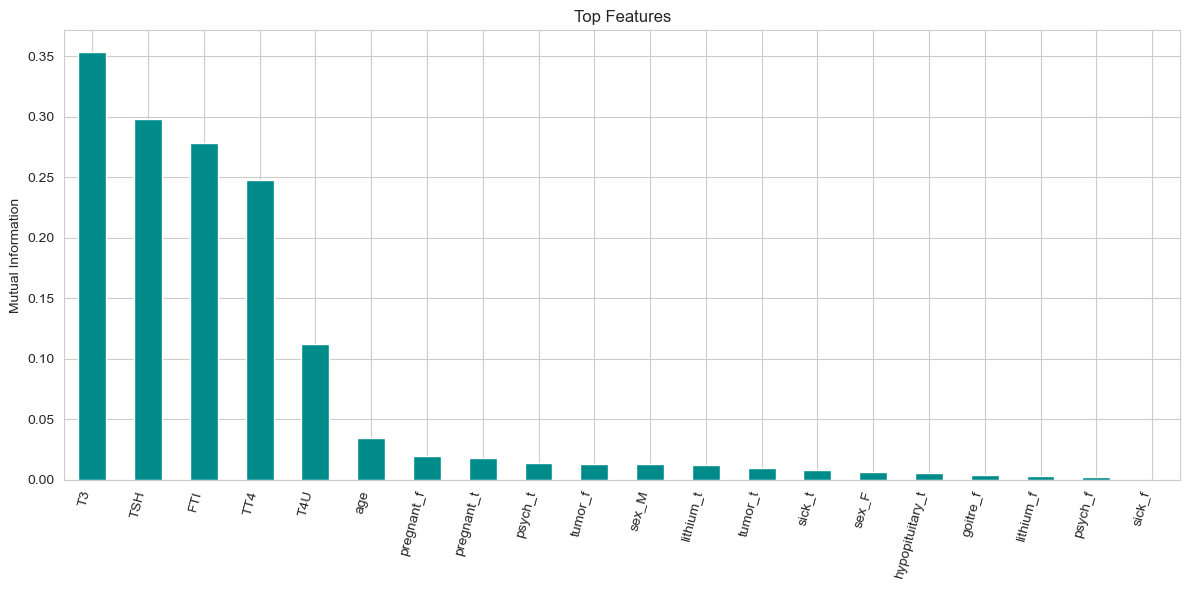

T3                 0.353757
TSH                0.298293
FTI                0.278074
TT4                0.247978
T4U                0.112407
age                0.034187
pregnant_f         0.019646
pregnant_t         0.018153
psych_t            0.013391
tumor_f            0.013267
sex_M              0.012635
lithium_t          0.011749
tumor_t            0.009594
sick_t             0.008095
sex_F              0.005977
hypopituitary_t    0.005569
goitre_f           0.004017
lithium_f          0.002802
psych_f            0.002284
sick_f             0.000000
dtype: float64

In [42]:
# Mutual information
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer

# drop na
df=data_6class.drop(columns=["TBG"]).copy()
df.dropna(inplace=True)

# cat / num
cat_cols = df.select_dtypes(include='object').drop(columns=['target']).columns.tolist()
num_cols = df.select_dtypes(exclude='object').columns.tolist()


X = df[num_cols + cat_cols]
y = df['target']

# encode targets
le = LabelEncoder()
y_enc = le.fit_transform(y)

# onehot categoriel
ct = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
], remainder='passthrough')

X_enc = ct.fit_transform(X)

#nom colonnes
cat_feature_names = ct.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_feature_names = list(cat_feature_names) + num_cols  # numériques à la fin

mi = mutual_info_classif(X_enc, y_enc, random_state=42)
mi_series = pd.Series(mi, index=all_feature_names).sort_values(ascending=False)

# --- Plot ---
plt.figure(figsize=(12,6))
mi_series.head(20).plot(kind='bar', color='darkcyan')
plt.title("Top Features")
plt.ylabel("Mutual Information")
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

mi_series.head(20)



Avec les 6 classes diagnostiques, l’analyse par information mutuelle met en évidence une redistribution de l’importance des biomarqueurs. Le T3 devient la variable la plus informative, devant la TSH, la TT4 et la FTI. Cela s’explique par l’ajout de classes : alors que la TSH distingue principalement hypo- versus hyperthyroïdie, l’introduction de sous-types amène le modèle à exploiter davantage des marqueurs comme le T3, mieux adaptés pour différencier certaines présentations hyperthyroïdiennes.

Les biomarqueurs hormonaux restent ainsi de loin les plus déterminants, tandis que les variables cliniques n’apportent qu’une contribution marginale.

L’âge gagne également en importance dans cette version du modèle, ce qui est cohérent avec la distribution clinique observée : les pathologies non-thyroïdiennes concomitantes et les formes compensées d’hypothyroïdie sont plus fréquentes chez les sujets âgés, alors que les troubles de liaison hormonale semblent davantage représenter une population plus jeune (< 40 ans). Et ce sont des classes que nous n'avions pas dans le modèle 3 classes.

/Users/mafaldafrere/miniforge3/envs/env_numpy/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


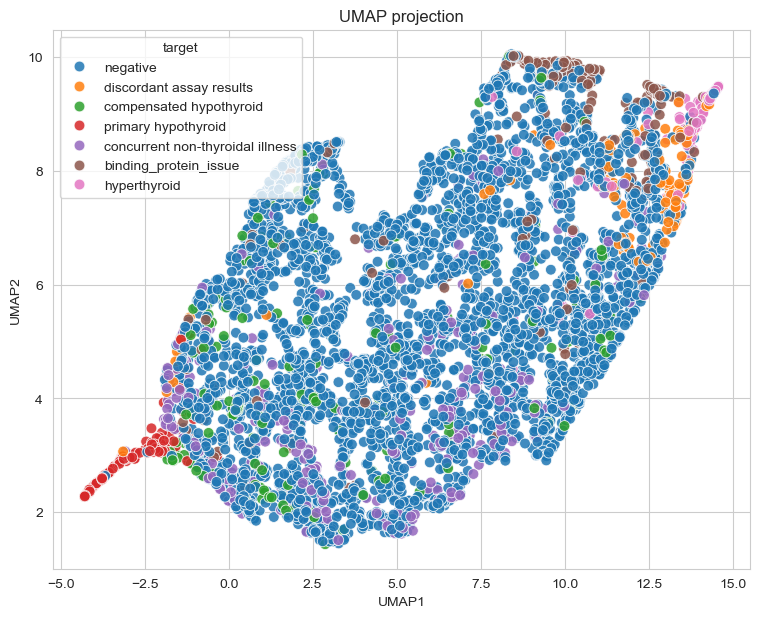

In [43]:
# visu umap 

import umap

embedding = umap.UMAP(random_state=42).fit_transform(X_enc)

umap_df = pd.DataFrame(embedding, columns=['UMAP1','UMAP2'])
umap_df['target'] = y.values

plt.figure(figsize=(9,7))
sns.scatterplot(
    data=umap_df,
    x='UMAP1', y='UMAP2',
    hue='target',
    palette="tab10",
    s=60, alpha=0.85
)
plt.title("UMAP projection")
plt.show()

Le u-map identifie très bien la classe primary hypothyroid : elle faisait partie de la meta classe hypothyroidie dans le modèle 3 classes, avec compensated hypothyroid qui est ici aussi assez disséminée. La classe hyperthyroid est à l'opposé. (On peut imaginer un gradient de TSH qui va du bras rouge : primary hypothyroid au bras rose : hyperthyroid, ce sont bien des diagnostics opposés en termes physiologique.) On identifie assez bien un cluster binding protein issue et discordant assay results également. Concurrent non thyroidal illness est disséminé. 

## C. Analyse valeurs manquantes
Dans un contexte médical, faire de l'imputation peut bruiter nos données. En effet, les hormones (TSH, T3, TT4, etc.) portent le signal principal du diagnostic. Ces tests ne sont pas toujours demandés par le clinicien, leur absence n'est pas aléatoire : elle reflète une décision médicale. Non seulement l'absence/présence est un signal, mais en plus, imputer avec une valeur médiane/moyenne reviendrait à modifier le diagnostic et donc la target de manière significative (pour les NA sur les hormones). 

On va faire une courte analyse du nombre de Na, et dans quelles colonnes pour voir comment les gérer.

XGBoost serait capable de gérer les Na, cela peut être beaucoup pertinent comme approche. 

<Axes: >

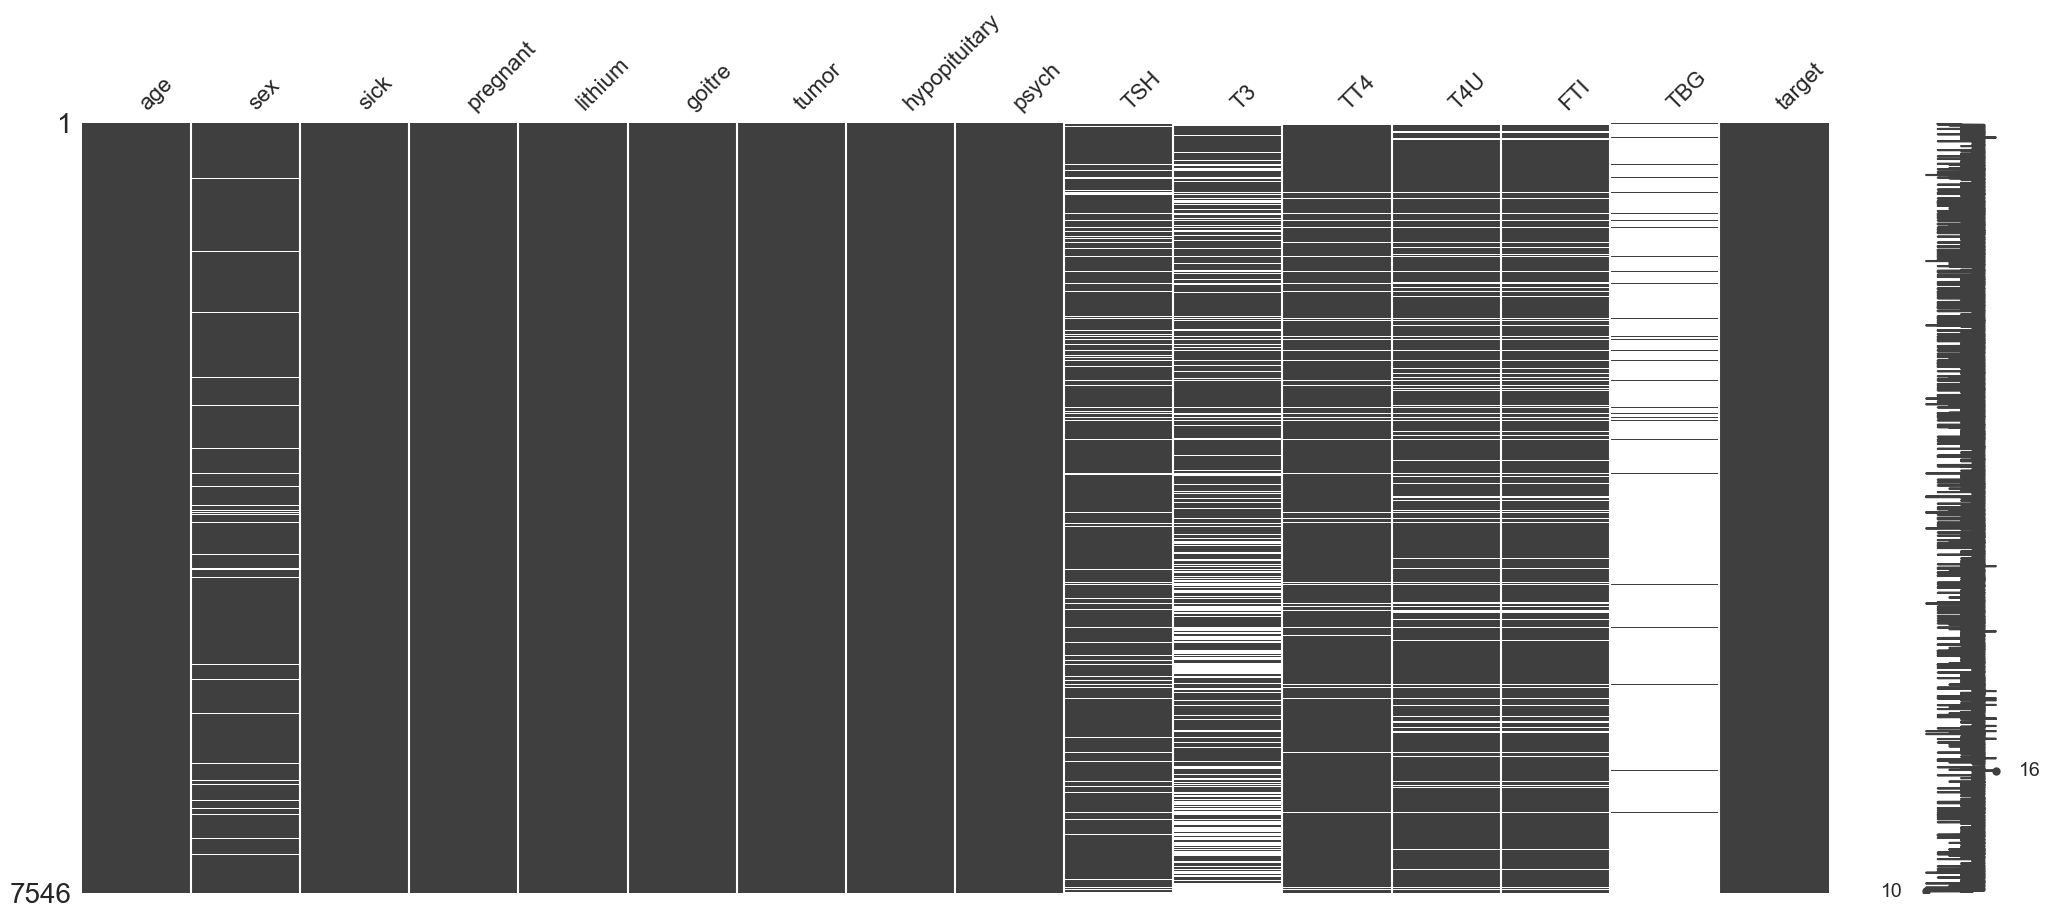

In [44]:
import missingno as msno
msno.matrix(data_3class)

In [45]:
# pourcentage de valeurs manquantes par colonne
na_counts = data_3class.isna().sum()
na_percent = (na_counts / len(data_3class)) * 100

# dataframe pr résumé
na_summary = pd.DataFrame({
    'Missing Count': na_counts,
    'Missing (%)': na_percent
})

# afficher que les colonnes avec au moins 1 NA
na_summary = na_summary[na_summary['Missing Count'] > 0].sort_values(by='Missing (%)', ascending=False)

# Affichage
display(na_summary)

Missing Count  Missing (%)
TBG           7287    96.567718
T3            2209    29.273787
TSH            722     9.567983
T4U            676     8.958389
FTI            669     8.865624
TT4            354     4.691227
sex            250     3.313014
age              4     0.053008

Je vais drop la colonne TBG, car elle contient plus de 96% de valeurs manquantes, n’apporte pas de pouvoir discriminant clair (cf pairplots..), et pourrait biaiser l’apprentissage.

Pour les hormones thyroïdiennes (TSH, T3, TT4, FTI, T4U), il est délicat de les imputer car leur absence reflète souvent une décision médicale de ne pas doser (et non un oubli). Je pense les laisser manquantes pour XGBoost (car il tolère les NaN et saura en tirer l'information), par contre pour les autres modèles : je vais probablement imputer ces colonnes mais rajouter les colonnes "hormone_mesurée" (oui/non) pour que le modèle discrimine sur ça et non sur la valeur imputée. 

Pour le reste, on fera de l'imputation (ce ne sont pas les variables centrales).

# 4. Feature Engineering
On va maintenant essayer d'augmenter nos performances en faisant du feature engineering sur nos variables.

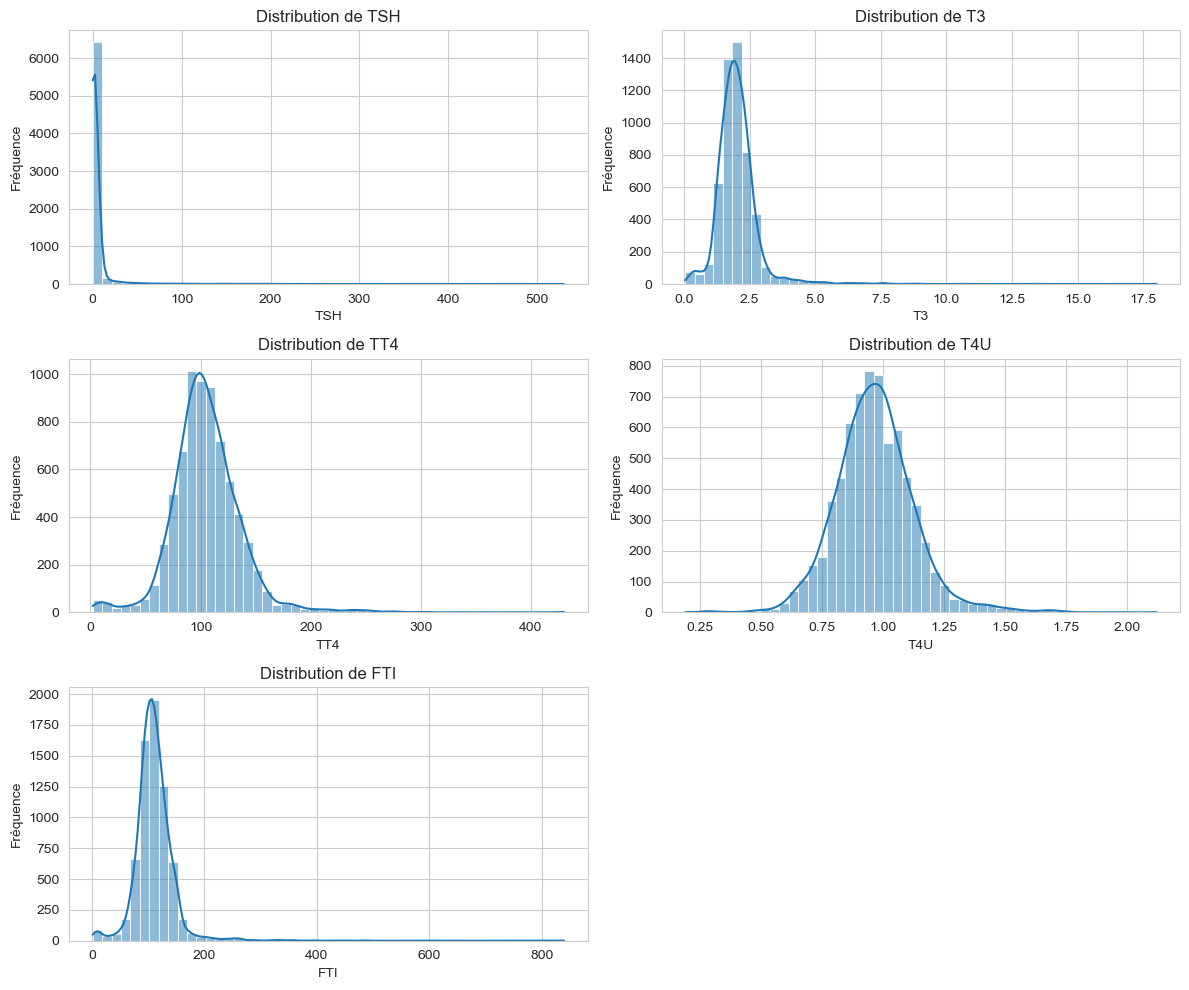

In [46]:
hormones = ['TSH','T3','TT4','T4U','FTI']

plt.figure(figsize=(12,10))

for i, h in enumerate(hormones, 1):
    plt.subplot(3,2,i)
    sns.histplot(data_3class[h], bins=50, kde=True)
    plt.title(f"Distribution de {h}")
    plt.xlabel(h)
    plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()


Parmi les hormones thyroïdiennes, seule la TSH présente une distribution fortement asymétrique, avec un grand nombre de valeurs proches de zéro et une longue queue droite.
Cela reflète la physiologie : la TSH chute quasiment à 0 dans l’hyperthyroïdie sévère, alors qu’elle peut atteindre des valeurs très élevées en hypothyroïdie.
À l’inverse, les hormones périphériques (T3, TT4, FTI, T4U) présentent des distributions plus proches d'une normale, mais on garde des longues queues droites quand même (sauf T4U). **On peut essayer de faire une transformation logarithmique de nos variables.**

D'autre part, la régulation thyroïdienne repose sur un mécanisme de rétro-contrôle entre l’hypophyse et la glande thyroïde.
La TSH stimule la production de T3 et T4, et ces hormones inhibent en retour la sécrétion de TSH.
Ainsi, ce n’est pas seulement la valeur absolue d’une hormone qui importe, mais le rapport entre TSH et T3/T4.
Créer des ratios (T3/TSH et TT4/TSH) permet de capturer ce mécanisme physiologique!  **On va donc créer ces ratios et voir s'ils peuvent apporter de l'information supplémentaire.**

Certaines anomalies thyroïdiennes ne proviennent pas d’un dysfonctionnement glandulaire, mais de problèmes de transport et de liaison des hormones aux protéines circulantes, ou de discordances analytiques dans les dosages. Le marqueur "FTI" peut-être reconstitué synthétiquement en calculant TT4 × T4U. En mesurant l'écart entre ce FTI synthétique et le FTI observé on pourrait mieux détecter les pathologies de protéines de liaisons et les discordant assay results (interférences analytiques). **On va donc créer une feature FTI_synth et une FTI_diff pour voir la différence entre le FTI observé et le FTI calculé et voir si ces métriques peuvent améliorer les performances.**

**Enfin, on peut bin les taux d'hormones avec des seuils quantiles low/high pour aider à la prédiction.**

In [47]:
data_3class_augmented=data_3class.copy()
eps = 1e-6 # pour éviter division par 0 !!!

for c in ['TSH','T3','TT4','FTI']:
    data_3class_augmented[f'log_{c}'] = np.log1p(data_3class_augmented[c].clip(lower=0))

# ratios
data_3class_augmented['ratio_TT4_TSH'] = data_3class_augmented['TT4'] / (data_3class_augmented['TSH'] + eps)
data_3class_augmented['ratio_T3_TSH'] = data_3class_augmented['T3'] / (data_3class_augmented['TSH'] + eps)

# FTI synth & diff
data_3class_augmented['FTI_synth'] = data_3class_augmented['TT4'] * data_3class_augmented['T4U']
data_3class_augmented['FTI_diff'] = (data_3class_augmented['FTI'] - data_3class_augmented['FTI_synth']).abs()


# quantiles +- = des seuils biologiques
q_tsh_low, q_tsh_high = data_3class_augmented['TSH'].quantile([0.1, 0.9])
q_t3_high = data_3class_augmented['T3'].quantile(0.9)
q_tt4_high = data_3class_augmented['TT4'].quantile(0.9)

data_3class_augmented['flag_tsh_low']  = (data_3class_augmented['TSH'] <= q_tsh_low).astype(int)
data_3class_augmented['flag_tsh_high'] = (data_3class_augmented['TSH'] >= q_tsh_high).astype(int)
data_3class_augmented['flag_t3_high']  = (data_3class_augmented['T3'] >= q_t3_high).astype(int)
data_3class_augmented['flag_tt4_high'] = (data_3class_augmented['TT4'] >= q_tt4_high).astype(int)

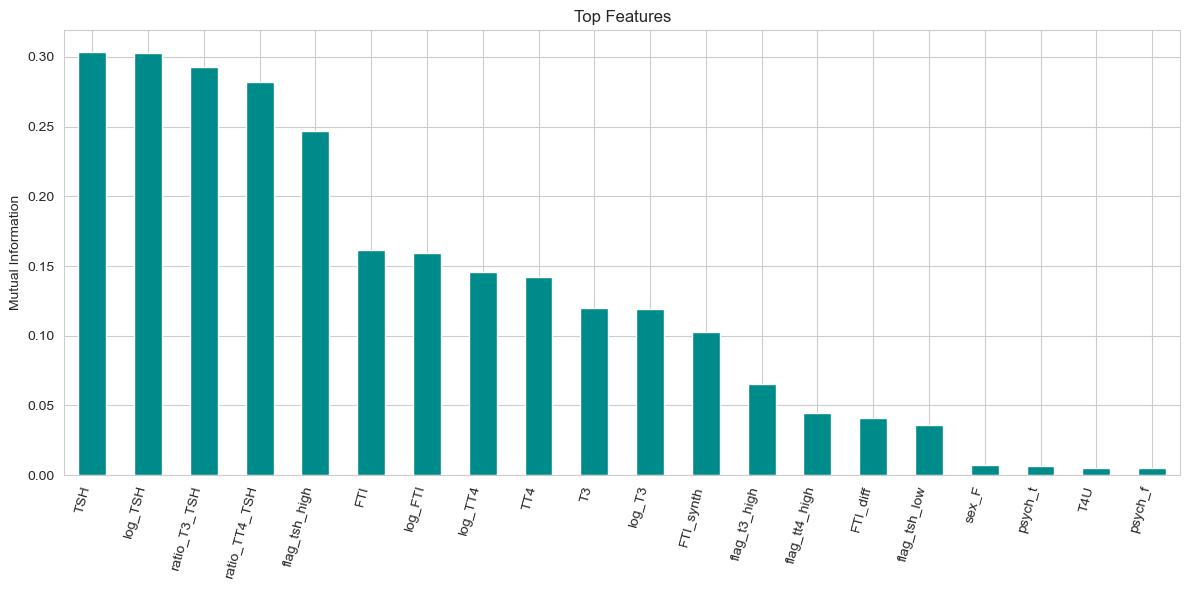

TSH              0.303813
log_TSH          0.303101
ratio_T3_TSH     0.292547
ratio_TT4_TSH    0.282330
flag_tsh_high    0.246838
FTI              0.161414
log_FTI          0.159258
log_TT4          0.145944
TT4              0.142051
T3               0.120103
log_T3           0.118990
FTI_synth        0.102626
flag_t3_high     0.065531
flag_tt4_high    0.044650
FTI_diff         0.040876
flag_tsh_low     0.036214
sex_F            0.007392
psych_t          0.006494
T4U              0.004997
psych_f          0.004893
dtype: float64

In [48]:
# Mutual information
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer

# drop na
df=data_3class_augmented.drop(columns=["TBG"]).copy()
df.dropna(inplace=True)

# cat / num
cat_cols = df.select_dtypes(include='object').drop(columns=['target']).columns.tolist()
num_cols = df.select_dtypes(exclude='object').columns.tolist()


X = df[num_cols + cat_cols]
y = df['target']

# encode targets
le = LabelEncoder()
y_enc = le.fit_transform(y)

# onehot categoriel
ct = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
], remainder='passthrough')

X_enc = ct.fit_transform(X)

#nom colonnes
cat_feature_names = ct.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_feature_names = list(cat_feature_names) + num_cols  # numériques à la fin

mi = mutual_info_classif(X_enc, y_enc, random_state=42)
mi_series = pd.Series(mi, index=all_feature_names).sort_values(ascending=False)

# --- Plot ---
plt.figure(figsize=(12,6))
mi_series.head(20).plot(kind='bar', color='darkcyan')
plt.title("Top Features")
plt.ylabel("Mutual Information")
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

mi_series.head(20)



L'information mutuelle confirme l’intérêt du feature engineering physiologique :
Les ratios T3/TSH et TT4/TSH deviennent les variables les plus informatives après la TSH, montrant qu’ils capturent le mécanisme de rétro-contrôle thyroïdien.

Je me questionne sur l'utilisation des transformations log sur les taux hormonaux car ici les outliers sont informatifs....

Les indicateurs d’extrêmes hormonaux (flags percentiles) reproduisent efficacement les seuils cliniques.

Les variables synthétiques autour du FTI ne sont pas forcément très concluants. 

Regardons si ces nouvelles variables peuvent être intéressantes pour le dataset 6 classes : 

In [49]:
data_6class_augmented=data_6class.copy()
eps = 1e-6 # pour éviter division par 0 !!!

for c in ['TSH','T3','TT4','FTI']:
    data_6class_augmented[f'log_{c}'] = np.log1p(data_6class_augmented[c].clip(lower=0))

# ratios
data_6class_augmented['ratio_TT4_TSH'] = data_6class_augmented['TT4'] / (data_6class_augmented['TSH'] + eps)
data_6class_augmented['ratio_T3_TSH'] = data_6class_augmented['T3'] / (data_6class_augmented['TSH'] + eps)

# FTI synth & diff
data_6class_augmented['FTI_synth'] = data_6class_augmented['TT4'] * data_6class_augmented['T4U']
data_6class_augmented['FTI_diff'] = (data_6class_augmented['FTI'] - data_6class_augmented['FTI_synth']).abs()


# quantiles +- = des seuils biologiques
q_tsh_low, q_tsh_high = data_6class_augmented['TSH'].quantile([0.1, 0.9])
q_t3_high = data_6class_augmented['T3'].quantile(0.9)
q_tt4_high = data_6class_augmented['TT4'].quantile(0.9)

data_6class_augmented['flag_tsh_low']  = (data_6class_augmented['TSH'] <= q_tsh_low).astype(int)
data_6class_augmented['flag_tsh_high'] = (data_6class_augmented['TSH'] >= q_tsh_high).astype(int)
data_6class_augmented['flag_t3_high']  = (data_6class_augmented['T3'] >= q_t3_high).astype(int)
data_6class_augmented['flag_tt4_high'] = (data_6class_augmented['TT4'] >= q_tt4_high).astype(int)

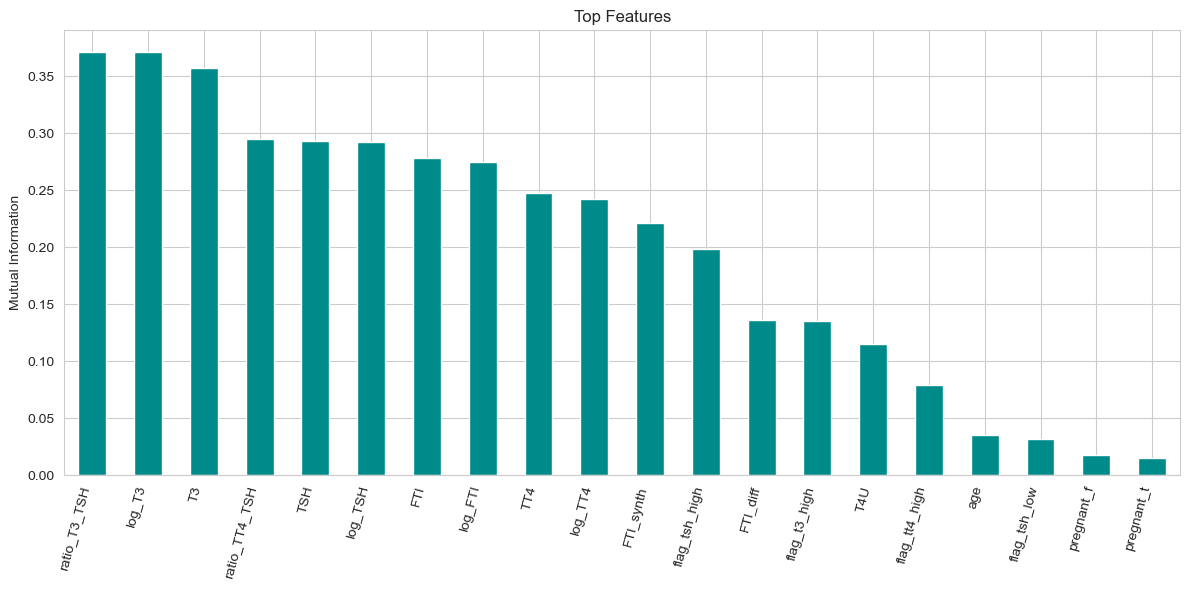

ratio_T3_TSH     0.371509
log_T3           0.370903
T3               0.357374
ratio_TT4_TSH    0.294761
TSH              0.293296
log_TSH          0.292440
FTI              0.278448
log_FTI          0.274582
TT4              0.247183
log_TT4          0.241981
FTI_synth        0.221195
flag_tsh_high    0.198286
FTI_diff         0.136245
flag_t3_high     0.135577
T4U              0.114820
flag_tt4_high    0.079346
age              0.035680
flag_tsh_low     0.031459
pregnant_f       0.017598
pregnant_t       0.015004
dtype: float64

In [50]:
# Mutual information
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer

# drop na
df=data_6class_augmented.drop(columns=["TBG"]).copy()
df.dropna(inplace=True)

# cat / num
cat_cols = df.select_dtypes(include='object').drop(columns=['target']).columns.tolist()
num_cols = df.select_dtypes(exclude='object').columns.tolist()


X = df[num_cols + cat_cols]
y = df['target']

# encode targets
le = LabelEncoder()
y_enc = le.fit_transform(y)

# onehot categoriel
ct = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
], remainder='passthrough')

X_enc = ct.fit_transform(X)

#nom colonnes
cat_feature_names = ct.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_feature_names = list(cat_feature_names) + num_cols  # numériques à la fin

mi = mutual_info_classif(X_enc, y_enc, random_state=42)
mi_series = pd.Series(mi, index=all_feature_names).sort_values(ascending=False)

# --- Plot ---
plt.figure(figsize=(12,6))
mi_series.head(20).plot(kind='bar', color='darkcyan')
plt.title("Top Features")
plt.ylabel("Mutual Information")
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

mi_series.head(20)



Ici aussi, certaines nouvelles variables ont une feature importance élevée ! Avec des différences par rapport au dataset 3 classes, vues globalement plut tôt.

# 5. Comparaison de modèles

## 3 classes

In [51]:
X_3class=data_3class.drop(columns=["target"])
y_3class=data_3class.target

In [52]:
# Trop de NA : On drop
X_3class=X_3class.drop(columns=["TBG"])

On garde une part du jeu d'entraînement pour le test final = X_train, X_test

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_3class, y_3class, 
    test_size=0.2, 
    stratify=y_3class,     # on impose la stratification car on a des classes déséquilibrées
    random_state=42
)

Feature Engineering "final":

In [54]:
# Transformers custom (les calculs de quantiles se font sur plusieurs lignes donc pour éviter fuite de données)
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Crée les features 'row-wise' (ratios, FTI_synth/diff)."""
    def __init__(self, eps=1e-6):
        self.eps = eps
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        eps = self.eps
        if {'TT4','TSH'}.issubset(X.columns):
            X['ratio_TT4_TSH'] = X['TT4'] / (X['TSH'] + eps)
        if {'T3','TSH'}.issubset(X.columns):
            X['ratio_T3_TSH'] = X['T3'] / (X['TSH'] + eps)
        if {'TT4','T4U'}.issubset(X.columns):
            X['FTI_synth'] = X['TT4'] * X['T4U']
        if {'FTI','FTI_synth'}.issubset(X.columns):
            X['FTI_diff'] = (X['FTI'] - X['FTI_synth']).abs()
        return X

class QuantileFlagger(BaseEstimator, TransformerMixin):
    """Calcule des flags via quantiles appris sur le train (pas de fuite)."""
    def __init__(self, q_low=0.10, q_high=0.90):
        self.q_low = q_low
        self.q_high = q_high
    def fit(self, X, y=None):
        self.tsh_low_  = X['TSH'].quantile(self.q_low)
        self.tsh_high_ = X['TSH'].quantile(self.q_high)
        self.t3_high_  = X['T3'].quantile(self.q_high)
        self.tt4_high_ = X['TT4'].quantile(self.q_high)
        return self
    def transform(self, X):
        X = X.copy()
        X['flag_tsh_low']  = (X['TSH'] <= self.tsh_low_).astype(int)
        X['flag_tsh_high'] = (X['TSH'] >= self.tsh_high_).astype(int)
        X['flag_t3_high']  = (X['T3']  >= self.t3_high_).astype(int)
        X['flag_tt4_high'] = (X['TT4'] >= self.tt4_high_).astype(int)
        return X

class MeasurementFlags(BaseEstimator, TransformerMixin):
    """Ajoute *_measured = 1 si non-NaN, 0 sinon."""

    def __init__(self, cols=None):
        self.cols = cols

    def fit(self, X, y=None):
        # Si cols=None → on prend toutes les num
        if self.cols is None:
            self.cols_ = X.select_dtypes(include=['float','int']).columns.tolist()
        else:
            # On copie pour éviter de modifier self.cols
            self.cols_ = [c for c in self.cols if c in X.columns]
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.cols_:
            X[f"{c}_measured"] = (~X[c].isna()).astype(int)
        return X



In [55]:
# colonnes d'origine
cat_cols = X_train.select_dtypes(include='object').columns.tolist()
num_cols_base = X_train.select_dtypes(exclude='object').columns.tolist()

# nouvelles colonnes créées par les transformers
eng_cols = ['ratio_TT4_TSH','ratio_T3_TSH','FTI_synth','FTI_diff',
            'flag_tsh_low','flag_tsh_high','flag_t3_high','flag_tt4_high']
meas_cols = ['TSH','T3','TT4','T4U','FTI']
meas_flag_cols = [f"{c}_measured" for c in meas_cols]

# jeu de colonnes numériques finales à traiter côté num (on inclut les nouvelles)
num_cols_all = list(dict.fromkeys(num_cols_base + eng_cols + meas_flag_cols))

On va maintenant benchmark plusieurs modèles (Logistic Regression, RF, XGBoost) sur le jeu 3 classes : 

In [56]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Preprocessing par modèle : 

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# LR : imputation + scaling sur numériques
num_pipe_lr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# RF : imputation seulement (pas de scaling)
num_pipe_tree = SimpleImputer(strategy="median")

preprocessor_logreg = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe_lr, num_cols_all),
], remainder="drop")

preprocessor_rf = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe_tree, num_cols_all),
], remainder="drop")

# XGB : on ne touche pas aux NaN numériques (pas d'imputer), on encode juste les cats
preprocessor_xgb = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", "passthrough", num_cols_all),
], remainder="drop")


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

models = {
    "LogisticRegression": Pipeline([
        ("fe", FeatureEngineer()),
        ("flags_q", QuantileFlagger(q_low=0.10, q_high=0.90)),
        ("flags_meas", MeasurementFlags(cols=meas_cols)),
        ("prep", preprocessor_logreg),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ]),
    "RandomForest": Pipeline([
        ("fe", FeatureEngineer()),
        ("flags_q", QuantileFlagger(q_low=0.10, q_high=0.90)),
        ("flags_meas", MeasurementFlags(cols=meas_cols)),
        ("prep", preprocessor_rf),
        ("clf", RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1))
    ]),
    "XGBoost": Pipeline([
        ("fe", FeatureEngineer()),
        ("flags_q", QuantileFlagger(q_low=0.10, q_high=0.90)),
        ("flags_meas", MeasurementFlags(cols=meas_cols)),
        ("prep", preprocessor_xgb),  # numériques en passthrough -> NaN conservés
        ("clf", XGBClassifier(
            objective="multi:softprob",
            eval_metric="mlogloss",
            tree_method="hist",
            n_jobs=-1,
            random_state=42
        ))
    ])
}

# encodage des labels sinon erreur xgboost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

In [59]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipe in models.items():
    scores = cross_val_score(
        pipe,
        X_train,          
        y_train_enc,      
        cv=cv,
        scoring="f1_macro",
        n_jobs=1          
    )
    print(f"{name}: F1-macro CV = {scores.mean():.3f} ± {scores.std():.3f}")



LogisticRegression: F1-macro CV = 0.858 ± 0.010
RandomForest: F1-macro CV = 0.922 ± 0.010
XGBoost: F1-macro CV = 0.932 ± 0.018


Bons résultats ! Stables. A titre de comparaison, le modèle baseline plus haut en RF avait environ 0.91 de macro F1 (on a déjà amélioré), mais les conditions de test ne sont pas les mêmes donc on ne peut pas l'affirmer. Le modèle "gagnant" est le xgboost (on s'y attendait, il gère bien les classes déséquilibrées).

In [60]:
# Evaluation finale sur le test : on récup le meilleur modèle
best_name, best_pipe = max(models.items(), key=lambda kv: 
    cross_val_score(kv[1], X_train, y_train_enc, cv=cv, scoring="f1_macro", n_jobs=1).mean()
)
best_pipe.fit(X_train, y_train_enc)

# tout est appliqué direct
y_test_enc = le.transform(y_test)
y_pred_enc = best_pipe.predict(X_test)

In [61]:
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report

print(f"F1-macro: {f1_score(y_test_enc, y_pred_enc, average='macro'):.3f}")
print(f"Balanced Acc: {balanced_accuracy_score(y_test_enc, y_pred_enc):.3f}")
print(classification_report(y_test_enc, y_pred_enc, target_names=le.classes_, digits=3))


F1-macro: 0.915
Balanced Acc: 0.912
              precision    recall  f1-score   support

hyperthyroid      0.824     0.778     0.800        36
 hypothyroid      0.943     0.966     0.954       119
    negative      0.991     0.990     0.991      1355

    accuracy                          0.983      1510
   macro avg      0.919     0.912     0.915      1510
weighted avg      0.983     0.983     0.983      1510



Très bons résultats ! Il n'y a pas d'overfitting :) => On choisit XGBoost comme modèle final.

## 6 classes

In [62]:
X_6class=data_6class.drop(columns=["target"])
y_6class=data_6class.target

In [63]:
# Trop de NA : On drop
X_6class=X_6class.drop(columns=["TBG"])

On garde une part du jeu d'entraînement pour le test final = X_train, X_test

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_6class, y_6class, 
    test_size=0.2, 
    stratify=y_6class,     # on impose la stratification car on a des classes déséquilibrées
    random_state=42
)

On va maintenant benchmark plusieurs modèles (Logistic Regression, RF, XGBoost) sur le jeu 6 classes : 

In [67]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Preprocessing par modèle : 

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# LR : imputation + scaling sur numériques
num_pipe_lr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# RF : imputation seulement (pas de scaling)
num_pipe_tree = SimpleImputer(strategy="median")

preprocessor_logreg = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe_lr, num_cols_all),
], remainder="drop")

preprocessor_rf = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe_tree, num_cols_all),
], remainder="drop")

# XGB : on ne touche pas aux NaN numériques (pas d'imputer), on encode juste les cats
preprocessor_xgb = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", "passthrough", num_cols_all),
], remainder="drop")


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

models = {
    "LogisticRegression": Pipeline([
        ("fe", FeatureEngineer()),
        ("flags_q", QuantileFlagger(q_low=0.10, q_high=0.90)),
        ("flags_meas", MeasurementFlags(cols=meas_cols)),
        ("prep", preprocessor_logreg),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ]),
    "RandomForest": Pipeline([
        ("fe", FeatureEngineer()),
        ("flags_q", QuantileFlagger(q_low=0.10, q_high=0.90)),
        ("flags_meas", MeasurementFlags(cols=meas_cols)),
        ("prep", preprocessor_rf),
        ("clf", RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1))
    ]),
    "XGBoost": Pipeline([
        ("fe", FeatureEngineer()),
        ("flags_q", QuantileFlagger(q_low=0.10, q_high=0.90)),
        ("flags_meas", MeasurementFlags(cols=meas_cols)),
        ("prep", preprocessor_xgb),  # numériques en passthrough -> NaN conservés
        ("clf", XGBClassifier(
            objective="multi:softprob",
            eval_metric="mlogloss",
            tree_method="hist",
            n_jobs=-1,
            random_state=42
        ))
    ])
}

# encodage labels opur éviter erreur xgboost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

In [69]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipe in models.items():
    scores = cross_val_score(
        pipe,
        X_train,          
        y_train_enc,      # labels encodés
        cv=cv,
        scoring="f1_macro",
        n_jobs=1          
    )
    print(f"{name}: F1-macro CV = {scores.mean():.3f} ± {scores.std():.3f}")

LogisticRegression: F1-macro CV = 0.694 ± 0.011
RandomForest: F1-macro CV = 0.849 ± 0.009
XGBoost: F1-macro CV = 0.871 ± 0.002


Aussi de bons résultats, XGBoost est nettement meilleur ! A titre de comparaison, le modèle baseline plus haut en RF avait environ 0.85 de macro F1 (on a déjà amélioré avec XGBoost), mais les conditions de test ne sont pas les mêmes donc on ne peut pas l'affirmer. Le modèle "gagnant" est aussi le xgboost (on s'y attendait, il gère bien les classes déséquilibrées).

In [70]:
# Evaluation finale sur le test : on récup le meilleur modèle train
best_name, best_pipe = max(models.items(), key=lambda kv: 
    cross_val_score(kv[1], X_train, y_train_enc, cv=cv, scoring="f1_macro", n_jobs=1).mean()
)
best_pipe.fit(X_train, y_train_enc)

# tout est appliqué direct
y_test_enc = le.transform(y_test)
y_pred_enc = best_pipe.predict(X_test)

In [71]:
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report

print(f"F1-macro: {f1_score(y_test_enc, y_pred_enc, average='macro'):.3f}")
print(f"Balanced Acc: {balanced_accuracy_score(y_test_enc, y_pred_enc):.3f}")
print(classification_report(y_test_enc, y_pred_enc, target_names=le.classes_, digits=3))


F1-macro: 0.888
Balanced Acc: 0.892
                                  precision    recall  f1-score   support

           binding_protein_issue      0.829     0.808     0.818        78
         compensated hypothyroid      0.947     1.000     0.973        72
concurrent non-thyroidal illness      0.842     0.899     0.870        89
        discordant assay results      0.853     0.744     0.795        39
                    hyperthyroid      0.775     0.861     0.816        36
                        negative      0.976     0.972     0.974      1354
             primary hypothyroid      0.978     0.957     0.968        47

                        accuracy                          0.954      1715
                       macro avg      0.886     0.892     0.888      1715
                    weighted avg      0.954     0.954     0.954      1715



Très bons résultats (même meilleurs qu'au train)! Il n'y a pas l'air d'avoir d'overfitting non plus :) => On choisit XGBoost comme modèle final.

# 6. Tuning des Hyper-Paramètres

On se concentre maintenant sur XGBoost dont on va optimiser les paramètres avec Optuna : 

#### 3 classes :

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_3class, y_3class, 
    test_size=0.2, 
    stratify=y_3class,     # on impose la stratification car on a des classes déséquilibrées
    random_state=42
)

In [73]:
#reset index
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

from sklearn.preprocessing import LabelEncoder
le3 = LabelEncoder()
y_train_enc = le3.fit_transform(y_train)
y_test_enc  = le3.transform(y_test)

# Sanity checks
assert len(X_train) == len(y_train_enc)
assert set(np.unique(y_train)) == set(le3.classes_)


In [ ]:
# Optuna + XGBoost 
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def make_pipe_xgb(params):
    clf = XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=1,                
        random_state=42,
        **params
    )
    return Pipeline([
        ("fe", FeatureEngineer()),
        ("flags_q", QuantileFlagger(q_low=0.10, q_high=0.90)),
        ("flags_meas", MeasurementFlags(cols=meas_cols)),
        ("prep", preprocessor_xgb),  
        ("clf", clf),
    ])

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 700),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 1.0, log=True),
    }
    pipe = make_pipe_xgb(params)
    score = cross_val_score(
        pipe, X_train, y_train_enc,
        cv=cv, scoring="f1_macro", n_jobs=1
    ).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=False) 

print("Best F1-macro CV:", study.best_value)
print("Best params:", study.best_params)

# Fit final avec les meilleurs hyperparamètres
best_pipe = make_pipe_xgb(study.best_params)
best_pipe.fit(X_train, y_train_enc)

[I 2025-11-03 20:14:55,005] A new study created in memory with name: no-name-7cdbad5c-9a4c-4591-95dc-b438e8f9cf1e
[I 2025-11-03 20:15:02,726] Trial 0 finished with value: 0.9202360855402405 and parameters: {'n_estimators': 282, 'max_depth': 8, 'learning_rate': 0.13376965672559513, 'subsample': 0.7173407150906183, 'colsample_bytree': 0.6356678796424863, 'min_child_weight': 1, 'reg_lambda': 1.7070165190551498, 'reg_alpha': 0.06798877891824566}. Best is trial 0 with value: 0.9202360855402405.
[I 2025-11-03 20:15:15,255] Trial 1 finished with value: 0.915718299523749 and parameters: {'n_estimators': 515, 'max_depth': 6, 'learning_rate': 0.01975115434217317, 'subsample': 0.827116304426249, 'colsample_bytree': 0.8445119928037337, 'min_child_weight': 7, 'reg_lambda': 0.1884463646816247, 'reg_alpha': 0.07357674157416452}. Best is trial 0 with value: 0.9202360855402405.
[I 2025-11-03 20:15:22,931] Trial 2 finished with value: 0.9062212136469583 and parameters: {'n_estimators': 432, 'max_depth':

Best F1-macro CV: 0.9323040595327928
Best params: {'n_estimators': 698, 'max_depth': 8, 'learning_rate': 0.05897199497174934, 'subsample': 0.6108150136804683, 'colsample_bytree': 0.9920081670891798, 'min_child_weight': 1, 'reg_lambda': 0.3593649980773761, 'reg_alpha': 0.0013520849815714469}


Pipeline(steps=[('fe', FeatureEngineer()), ('flags_q', QuantileFlagger()),
                ('flags_meas',
                 MeasurementFlags(cols=['TSH', 'T3', 'TT4', 'T4U', 'FTI'])),
                ('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'sick', 'pregnant',
                                                   'lithium', 'goitre', 't...
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.05897199497174934, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=698, n_jobs=1,
                               num_parallel_tree=None, ...))])

In [75]:
# Éval test 
y_test_enc = le3.transform(y_test)
y_pred_enc = best_pipe.predict(X_test) 

from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report
print(f"Test F1-macro: {f1_score(y_test_enc, y_pred_enc, average='macro'):.3f}")
print(f"Test Balanced Acc: {balanced_accuracy_score(y_test_enc, y_pred_enc):.3f}")
print(classification_report(y_test_enc, y_pred_enc, target_names=le3.classes_, digits=3))

Test F1-macro: 0.922
Test Balanced Acc: 0.926
              precision    recall  f1-score   support

hyperthyroid      0.829     0.806     0.817        36
 hypothyroid      0.936     0.983     0.959       119
    negative      0.993     0.990     0.991      1355

    accuracy                          0.985      1510
   macro avg      0.919     0.926     0.922      1510
weighted avg      0.985     0.985     0.985      1510



Optuna n'apporte pas énormément de pouvoir prédictif. Les résultats sont déjà très bons avec les paramètres par défaut. 

Si on avait plus de temps, on pourrait mettre + de trials, tester du gridsearch... etc 

## 6 classes

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_6class, y_6class, 
    test_size=0.2, 
    stratify=y_6class,     # on impose la stratification car on a des classes déséquilibrées
    random_state=42
)

In [77]:
#reset index
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

from sklearn.preprocessing import LabelEncoder
le6 = LabelEncoder()
y_train_enc = le6.fit_transform(y_train)
y_test_enc  = le6.transform(y_test)

# Sanity checks
assert len(X_train) == len(y_train_enc)
assert set(np.unique(y_train)) == set(le6.classes_)


In [ ]:
# Optuna + XGBoost 
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def make_pipe_xgb(params):
    clf = XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=1,                
        random_state=42,
        **params
    )
    return Pipeline([
        ("fe", FeatureEngineer()),
        ("flags_q", QuantileFlagger(q_low=0.10, q_high=0.90)),
        ("flags_meas", MeasurementFlags(cols=meas_cols)),
        ("prep", preprocessor_xgb),  
        ("clf", clf),
    ])

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 700),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 1.0, log=True),
    }
    pipe = make_pipe_xgb(params)
    score = cross_val_score(
        pipe, X_train, y_train_enc,
        cv=cv, scoring="f1_macro", n_jobs=1
    ).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=False) 

print("Best F1-macro CV:", study.best_value)
print("Best params:", study.best_params)

# Fit final avec les meilleurs hyperparamètres
best_pipe = make_pipe_xgb(study.best_params)
best_pipe.fit(X_train, y_train_enc)

[I 2025-11-03 20:19:14,282] A new study created in memory with name: no-name-17cd3cb9-5ba1-4303-b5b9-a6c1957b6ea7


[I 2025-11-03 20:19:46,363] Trial 0 finished with value: 0.865039910694079 and parameters: {'n_estimators': 661, 'max_depth': 5, 'learning_rate': 0.08863116198351464, 'subsample': 0.9331392958837511, 'colsample_bytree': 0.6756453245358972, 'min_child_weight': 4, 'reg_lambda': 2.328273747969287, 'reg_alpha': 0.7413466506052162}. Best is trial 0 with value: 0.865039910694079.
[I 2025-11-03 20:20:06,041] Trial 1 finished with value: 0.8547660035019703 and parameters: {'n_estimators': 474, 'max_depth': 3, 'learning_rate': 0.01779184315470169, 'subsample': 0.6386338608463885, 'colsample_bytree': 0.8593598651845028, 'min_child_weight': 3, 'reg_lambda': 0.00800081608569303, 'reg_alpha': 0.08856867854670743}. Best is trial 0 with value: 0.865039910694079.
[I 2025-11-03 20:20:25,249] Trial 2 finished with value: 0.8599519480572575 and parameters: {'n_estimators': 536, 'max_depth': 5, 'learning_rate': 0.1972560475624902, 'subsample': 0.7887016749936976, 'colsample_bytree': 0.9658579273992931, 'm

Best F1-macro CV: 0.8764239005218425
Best params: {'n_estimators': 348, 'max_depth': 7, 'learning_rate': 0.07933721601654567, 'subsample': 0.8898161487199393, 'colsample_bytree': 0.8878424596776628, 'min_child_weight': 1, 'reg_lambda': 0.3150375452251718, 'reg_alpha': 0.09920676685686047}


Pipeline(steps=[('fe', FeatureEngineer()), ('flags_q', QuantileFlagger()),
                ('flags_meas',
                 MeasurementFlags(cols=['TSH', 'T3', 'TT4', 'T4U', 'FTI'])),
                ('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'sick', 'pregnant',
                                                   'lithium', 'goitre', 't...
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.07933721601654567, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=348, n_jobs=1,
                               num_parallel_tree=None, ...))])

In [80]:
# Éval test 
y_test_enc = le6.transform(y_test)
y_pred_enc = best_pipe.predict(X_test) 

from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report
print(f"Test F1-macro: {f1_score(y_test_enc, y_pred_enc, average='macro'):.3f}")
print(f"Test Balanced Acc: {balanced_accuracy_score(y_test_enc, y_pred_enc):.3f}")
print(classification_report(y_test_enc, y_pred_enc, target_names=le6.classes_, digits=3))

Test F1-macro: 0.877
Test Balanced Acc: 0.876
                                  precision    recall  f1-score   support

           binding_protein_issue      0.838     0.795     0.816        78
         compensated hypothyroid      0.935     1.000     0.966        72
concurrent non-thyroidal illness      0.827     0.910     0.866        89
        discordant assay results      0.824     0.718     0.767        39
                    hyperthyroid      0.778     0.778     0.778        36
                        negative      0.977     0.974     0.976      1354
             primary hypothyroid      0.978     0.957     0.968        47

                        accuracy                          0.953      1715
                       macro avg      0.879     0.876     0.877      1715
                    weighted avg      0.953     0.953     0.953      1715



Supers résultats sur le test ! On a amélioré nos performances. 

# 7. Discussion & Conclusion 

Avec du recul, une amélioration clé consisterait à effectuer le split Train/Test plus tôt, afin d’éviter tout risque de fuite lors de l’analyse exploratoire ou du calcul des Mutual Information. Une attention plus poussée aurait également pu être portée à la gestion du déséquilibre des classes (sous-échantillonnage..) et au tuning des hyperparamètres (Optuna plus poussé, GridSearch).

Une extension naturelle du projet serait d’entraîner un modèle sur les ~20 classes originales du dataset, un défi plus proche du cas réel en clinique, notamment pour les diagnostics rares. D’autres algorithmes tabulaires performants comme LightGBM pourraient aussi être testés.

Enfin, j'aurai aussi voulu faire une interprétation post-hoc des variables utilisées par le modèles pour voir lesquelles sont importantes pour prédire chaque classes (type SHAP). Par manque de temps et parce que c'est + complexe pour du multi-classe, je ne l'ai pas fait.

 Malgré ces pistes, le pipeline construit obtient des résultats solides et fournit un premier travail d'exploration des données et de prédiction de diagnostic.